## <b><span style="color:blue">Import Libraries <b></span> 
    
Import some of the required libraries that we will need to build our anomaly detection solution.





In [311]:
# Main 
import os
import pandas as pd
import numpy as np
from pathlib import Path  
from datetime import date
# Data Visualization
import matplotlib.pyplot as plt
%matplotlib inline
from pandas.plotting import lag_plot

import seaborn as sns
# Seaborn Styling 
sns.set(
    font_scale=1.5,
    style="whitegrid",
    rc={'figure.figsize':(20,7)}
)
from matplotlib.dates import DateFormatter
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
# Data Preperation 
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from numpy import where
from collections import Counter
import scipy.stats

import statsmodels.api as sm

from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.stats.stattools import durbin_watson

# Algorithms 
from sklearn.ensemble import IsolationForest
from sklearn.ensemble import RandomForestClassifier 
from statsmodels.tsa.vector_ar.var_model import VAR
import lightgbm as lgb
import xgboost as x
import warnings
warnings.simplefilter('ignore')

## <span style="color:blue"><b>Loading the HAI Dataset </b></span>

The first step is data acquisition of the dataset.This contains the sensors reading from different parts of the system. The parse option is passed to the panda library to ensure the time column is classified as date time format.


In [312]:
filepath = Path('dataset/hai_data1.csv')
hai_data = pd.read_csv(filepath,header=0,parse_dates=['time'], index_col='time') 
hai_data_r = pd.read_csv(filepath, parse_dates=['time'])

## <span style="color:blue"><b>Summarize the Data </b></span>

We show the first five rows of the dataset . As you can see the data has been properly loaded:

In [313]:
hai_data.head()

P1_B2004  P1_B2016   P1_B3004    P1_B3005  P1_B4002  \
time                                                                       
2020-07-09 15:00:00   0.09874   1.25036  382.21698  1118.61084      32.0   
2020-07-09 15:00:00   0.09874   1.24944  382.21698  1118.61084      32.0   
2020-07-09 15:00:00   0.09874   1.24746  382.21698  1118.61084      32.0   
2020-07-09 15:00:00   0.09874   1.24624  382.21698  1118.61084      32.0   
2020-07-09 15:00:00   0.09874   1.24364  382.21698  1118.61084      32.0   

                     P1_FCV01D  P1_FCV03D    P1_FT03  P1_LCV01D   P1_LIT01  \
time                                                                         
2020-07-09 15:00:00   92.69160   69.76647  315.48346   13.97231  384.30737   
2020-07-09 15:00:00   92.64934   69.74272  315.10199   13.93358  384.30737   
2020-07-09 15:00:00   92.91075   69.77000  316.05570   13.95248  384.20517   
2020-07-09 15:00:00   92.92407   69.70607  315.10199   13.89971  384.25626   
2020-07-09 15:00:00   93.05405   69.76971  315.48346   13.94603  384.20517   

                     ...  P2_ASD  P2_CO_rpm  P2_RTR  P2_SIT01  P2_VTR01  \
time                 ...                                                  
2020-07-09 15:00:00  ...       0    54065.0    2880     774.0        10   
2020-07-09 15:00:00  ...       0    54073.0    2880     773.0        10   
2020-07-09 15:00:00  ...       0    54073.0    2880     773.0        10   
2020-07-09 15:00:00  ...       0    54086.0    2880     777.0        10   
2020-07-09 15:00:00  ...       0    54086.0    2880     778.0        10   

                     P2_VTR02  P3_LCP01D  P4_HT_PS  P4_ST_PS  attack  
time                                                                  
2020-07-09 15:00:00        10        136         0         0       0  
2020-07-09 15:00:00        10        136         0         0       0  
2020-07-09 15:00:00        10        136         0         0       0  
2020-07-09 15:00:00        10        136         0         0       0  
2020-07-09 15:00:00        10        136         0         0       0  

[5 rows x 22 columns]

Preliminary data analysis is an essential part of any data science project for quality check and structure.So we start by looking at the data shape  and data types.

In [314]:
print("HAI Dataset Shape:", hai_data.shape)

HAI Dataset Shape: (118800, 22)


In [315]:
hai_data_r.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118800 entries, 0 to 118799
Data columns (total 23 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   time       118800 non-null  datetime64[ns]
 1   P1_B2004   118800 non-null  float64       
 2   P1_B2016   118800 non-null  float64       
 3   P1_B3004   118800 non-null  float64       
 4   P1_B3005   118800 non-null  float64       
 5   P1_B4002   118800 non-null  float64       
 6   P1_FCV01D  118800 non-null  float64       
 7   P1_FCV03D  118800 non-null  float64       
 8   P1_FT03    118800 non-null  float64       
 9   P1_LCV01D  118800 non-null  float64       
 10  P1_LIT01   118800 non-null  float64       
 11  P1_PCV01D  118800 non-null  float64       
 12  P1_PIT01   118800 non-null  float64       
 13  P2_ASD     118800 non-null  int64         
 14  P2_CO_rpm  118800 non-null  float64       
 15  P2_RTR     118800 non-null  int64         
 16  P2_SIT01   118800 no

## <span style="color:blue"><b>Data Cleaning </b></span>
So before we visualize the dataset attributes and apply our models we need to clean the dataset  to remove redundant columns , remove duplicates and fix any other issues as follows:

### 1. Drop Duplicates  

In [316]:
hai_data = hai_data.drop_duplicates()
hai_data_r = hai_data_r.drop_duplicates()

### 2. Deleting Columns with Single Value & two values

In [317]:
hai_data_r.nunique()
hai_data.nunique()

P1_B2004         99
P1_B2016      18797
P1_B3004        119
P1_B3005        120
P1_B4002         96
P1_FCV01D     47326
P1_FCV03D    106100
P1_FT03        1890
P1_LCV01D    105384
P1_LIT01       3669
P1_PCV01D    110330
P1_PIT01       2094
P2_ASD            1
P2_CO_rpm      1060
P2_RTR            1
P2_SIT01        816
P2_VTR01          1
P2_VTR02          1
P3_LCP01D      1846
P4_HT_PS          2
P4_ST_PS          2
attack            2
dtype: int64

In [318]:
hai_data_r = hai_data_r.drop(['P2_ASD','P2_RTR','P2_VTR01','P2_VTR01','P2_VTR02','P4_ST_PS','P4_HT_PS'], axis = 1)
hai_data = hai_data.drop(['P2_ASD','P2_RTR','P2_VTR01','P2_VTR01','P2_VTR02','P4_ST_PS','P4_HT_PS'], axis = 1)
hai_data.columns

Index(['P1_B2004', 'P1_B2016', 'P1_B3004', 'P1_B3005', 'P1_B4002', 'P1_FCV01D',
       'P1_FCV03D', 'P1_FT03', 'P1_LCV01D', 'P1_LIT01', 'P1_PCV01D',
       'P1_PIT01', 'P2_CO_rpm', 'P2_SIT01', 'P3_LCP01D', 'attack'],
      dtype='object')

In [319]:
hai_data.head()

P1_B2004  P1_B2016   P1_B3004    P1_B3005  P1_B4002  \
time                                                                       
2020-07-09 15:00:00   0.09874   1.25036  382.21698  1118.61084      32.0   
2020-07-09 15:00:00   0.09874   1.24944  382.21698  1118.61084      32.0   
2020-07-09 15:00:00   0.09874   1.24746  382.21698  1118.61084      32.0   
2020-07-09 15:00:00   0.09874   1.24624  382.21698  1118.61084      32.0   
2020-07-09 15:00:00   0.09874   1.24364  382.21698  1118.61084      32.0   

                     P1_FCV01D  P1_FCV03D    P1_FT03  P1_LCV01D   P1_LIT01  \
time                                                                         
2020-07-09 15:00:00   92.69160   69.76647  315.48346   13.97231  384.30737   
2020-07-09 15:00:00   92.64934   69.74272  315.10199   13.93358  384.30737   
2020-07-09 15:00:00   92.91075   69.77000  316.05570   13.95248  384.20517   
2020-07-09 15:00:00   92.92407   69.70607  315.10199   13.89971  384.25626   
2020-07-09 15:00:00   93.05405   69.76971  315.48346   13.94603  384.20517   

                     P1_PCV01D  P1_PIT01  P2_CO_rpm  P2_SIT01  P3_LCP01D  \
time                                                                       
2020-07-09 15:00:00   83.46329   1.35437    54065.0     774.0        136   
2020-07-09 15:00:00   83.40041   1.35437    54073.0     773.0        136   
2020-07-09 15:00:00   83.34054   1.35513    54073.0     773.0        136   
2020-07-09 15:00:00   83.26884   1.35513    54086.0     777.0        136   
2020-07-09 15:00:00   83.18826   1.35437    54086.0     778.0        136   

                     attack  
time                         
2020-07-09 15:00:00       0  
2020-07-09 15:00:00       0  
2020-07-09 15:00:00       0  
2020-07-09 15:00:00       0  
2020-07-09 15:00:00       0

In [320]:
hai_data.tail()

P1_B2004  P1_B2016   P1_B3004    P1_B3005  P1_B4002  \
time                                                                       
2020-07-10 23:59:00   0.10121   1.31111  397.63785  1001.99799   33.6555   
2020-07-10 23:59:00   0.10121   1.30608  397.63785  1001.99799   33.6555   
2020-07-10 23:59:00   0.10121   1.30226  397.63785  1001.99799   33.6555   
2020-07-10 23:59:00   0.10121   1.29707  397.63785  1001.99799   33.6555   
2020-07-10 23:59:00   0.10121   1.29906  397.63785  1001.99799   33.6555   

                     P1_FCV01D  P1_FCV03D    P1_FT03  P1_LCV01D   P1_LIT01  \
time                                                                         
2020-07-10 23:59:00      100.0   51.52665  246.43968    8.62932  395.14420   
2020-07-10 23:59:00      100.0   51.51111  246.24898    8.68301  395.19528   
2020-07-10 23:59:00      100.0   51.54862  246.43968    8.71395  395.19528   
2020-07-10 23:59:00      100.0   51.57135  246.24898    8.71927  395.24640   
2020-07-10 23:59:00      100.0   51.55929  246.05821    8.74994  395.19528   

                     P1_PCV01D  P1_PIT01  P2_CO_rpm  P2_SIT01  P3_LCP01D  \
time                                                                       
2020-07-10 23:59:00   39.26814   1.38260    54102.0     784.0      10056   
2020-07-10 23:59:00   39.21347   1.38260    54132.0     782.0      10240   
2020-07-10 23:59:00   39.14607   1.38184    54156.0     783.0      10424   
2020-07-10 23:59:00   39.11773   1.38031    54140.0     780.0      10592   
2020-07-10 23:59:00   39.07794   1.36887    54127.0     782.0      10752   

                     attack  
time                         
2020-07-10 23:59:00       0  
2020-07-10 23:59:00       0  
2020-07-10 23:59:00       0  
2020-07-10 23:59:00       0  
2020-07-10 23:59:00       0

## <span style="color:blue"><b>Understanding the Data </b></span>

### Descriprtive statistics
Let’s summarize the distribution of each attribute

In [321]:
hai_data.describe().T

count          mean          std          min           25%  \
P1_B2004   118800.0      0.100169     0.001146      0.09804      0.098740   
P1_B2016   118800.0      1.395836     0.128718      1.03394      1.322710   
P1_B3004   118800.0    398.345735    10.159938    382.21698    396.063020   
P1_B3005   118800.0   1066.997030    43.182686    994.63568   1001.997990   
P1_B4002   118800.0     32.598736     0.676365     31.60939     32.000000   
P1_FCV01D  118800.0     63.135055    42.196906      0.00000     15.933228   
P1_FCV03D  118800.0     58.676169     5.307145     32.63621     52.010785   
P1_FT03    118800.0    285.119595    25.315517    120.17726    248.156240   
P1_LCV01D  118800.0     12.345066     4.812719      0.00000      9.628240   
P1_LIT01   118800.0    398.866872    13.557339    162.61324    394.786380   
P1_PCV01D  118800.0     67.741118    19.890890      0.00000     49.757860   
P1_PIT01   118800.0      1.386082     0.073331      0.09781      1.364290   
P2_CO_rpm  118800.0  54100.049520   110.418232  51648.00000  54092.000000   
P2_SIT01   118800.0    781.593375    33.335961      0.00000    780.000000   
P3_LCP01D  118800.0   4636.876263  5128.583076     -8.00000     72.000000   
attack     118800.0      0.029032     0.167897      0.00000      0.000000   

                    50%           75%          max  
P1_B2004       0.100480      0.101210      0.10136  
P1_B2016       1.391555      1.467390      1.99702  
P1_B3004     396.063020    405.692200    423.35199  
P1_B3005    1085.589360   1094.344850   1118.61084  
P1_B4002      32.615000     33.185500     33.65550  
P1_FCV01D    100.000000    100.000000    100.00000  
P1_FCV03D     60.678940     61.728143     91.43527  
P1_FT03      296.219910    301.369570    351.21292  
P1_LCV01D     13.118070     13.947715     97.00000  
P1_LIT01     397.648930    405.776490    552.07324  
P1_PCV01D     67.297405     84.542000    100.00000  
P1_PIT01       1.383360      1.397090      2.41943  
P2_CO_rpm  54106.000000  54119.000000  54758.00000  
P2_SIT01     784.000000    786.000000    895.00000  
P3_LCP01D   1976.000000   9680.000000  20592.00000  
attack         0.000000      0.000000      1.00000

### Skewness and Kurtosis
* Skew refers to the distribution  that assumed to be gaussian  that is shifted in one direction or another.  It allows you to improve the accuracy of your model and better data preparation. Skewness is a measure of the symmetry of a distribution.
* Kurtosis determines the heaviness of the distribution tails.

In [322]:
hai_data.skew()

P1_B2004     -0.705377
P1_B2016      0.283307
P1_B3004      0.738278
P1_B3005     -0.827154
P1_B4002      0.348575
P1_FCV01D    -0.385613
P1_FCV03D    -0.012298
P1_FT03      -0.841702
P1_LCV01D    10.275512
P1_LIT01     -2.973067
P1_PCV01D     0.055000
P1_PIT01     -0.779622
P2_CO_rpm   -20.085005
P2_SIT01    -22.685647
P3_LCP01D     0.662351
attack        5.610300
dtype: float64

In [323]:
hai_data.kurt()

P1_B2004      -1.097323
P1_B2016       0.939747
P1_B3004       0.691097
P1_B3005      -1.101928
P1_B4002      -1.099068
P1_FCV01D     -1.710821
P1_FCV03D      0.180407
P1_FT03       -0.881831
P1_LCV01D    167.755695
P1_LIT01      66.317929
P1_PCV01D     -1.090371
P1_PIT01      73.062468
P2_CO_rpm    435.245658
P2_SIT01     527.307623
P3_LCP01D     -1.195028
attack        29.475958
dtype: float64

### Class Distribution
We look at the number of instances of the class.

In [324]:
# class distribution
print(hai_data.groupby('attack').size())

attack
0    115351
1      3449
dtype: int64



## <span style="color:blue"><b>Data Analysis & Visualization</b></span>

### Exploratory Visualization

Although we could go ahead and dive into the modeling, there are plenty of insights that can be gained just by exploring the dataset further.
Let's plot the dataset to have a feel of what each value or predictor looks like. We are using matplotlib to plot the data. There are probably based on my visual inspection of the graphs below that couple of variables have some correlation. 

Boxplots indicate outliers on some of the sensors readings.

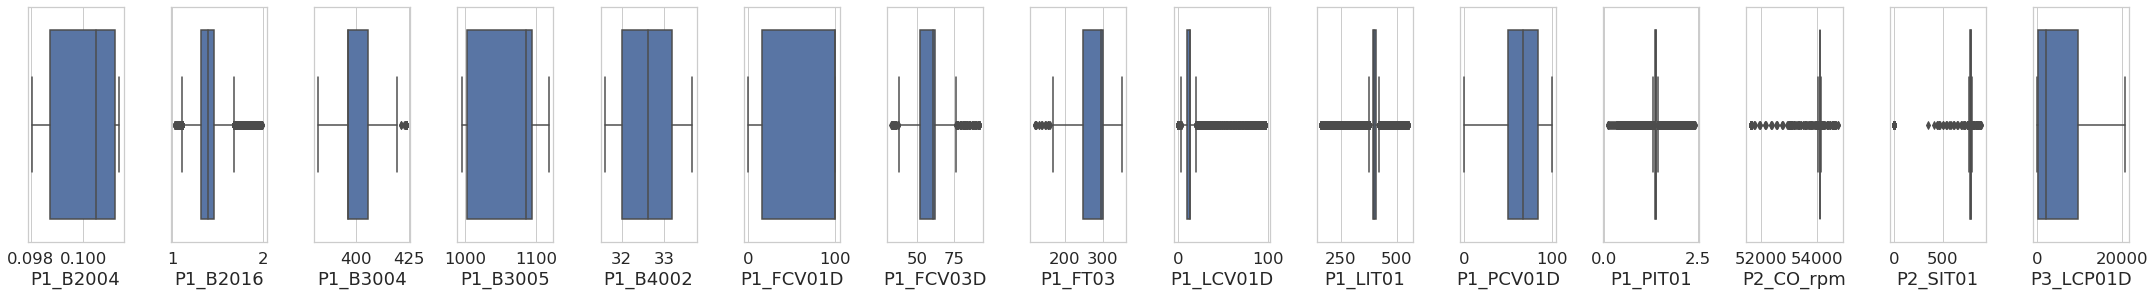

In [325]:
number_of_columns = len(hai_data.columns) 
plt.figure(figsize=(2*number_of_columns,8))
for category in range(0,number_of_columns - 1):
    plt.subplot(2 ,number_of_columns ,category+1)
    sns.boxplot(hai_data[hai_data.columns[category]], orient='v')
    plt.tight_layout()

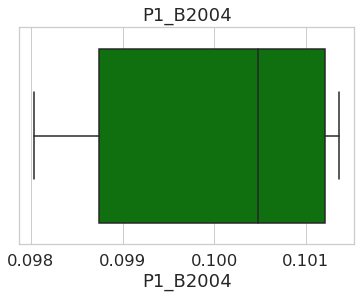

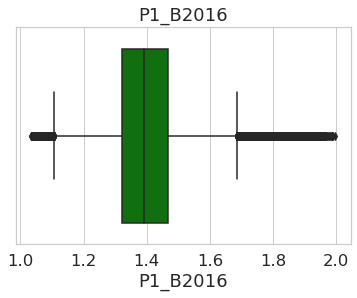

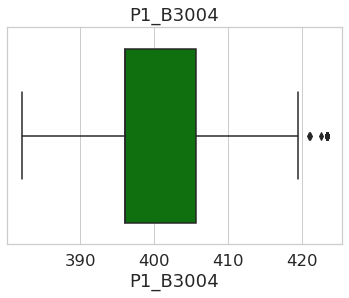

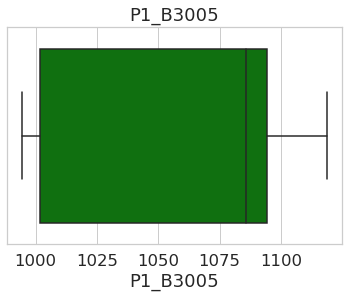

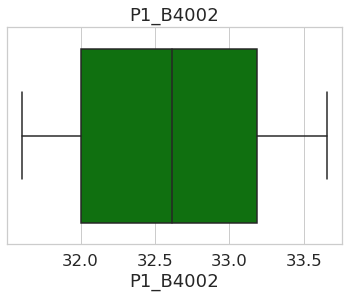

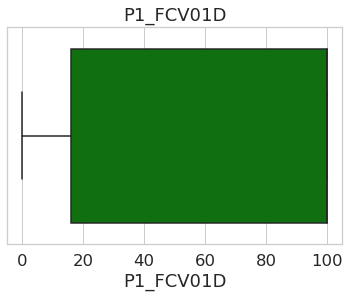

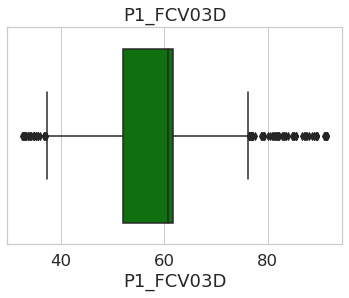

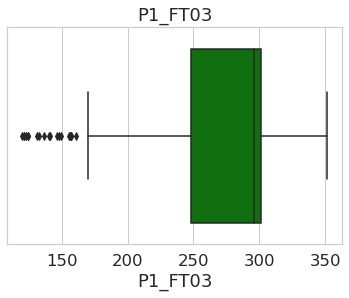

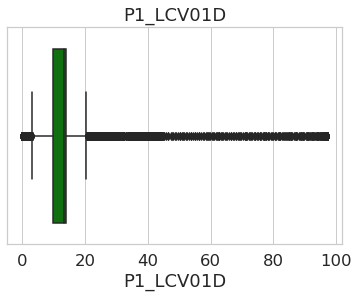

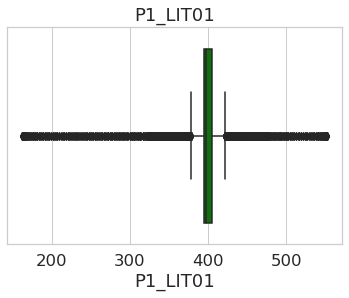

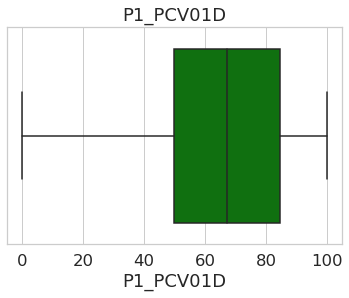

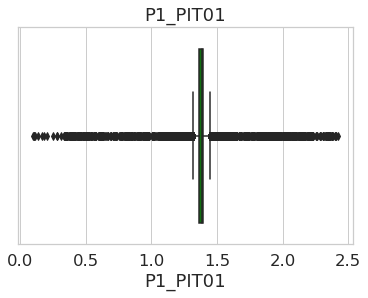

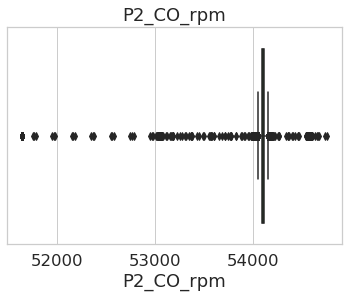

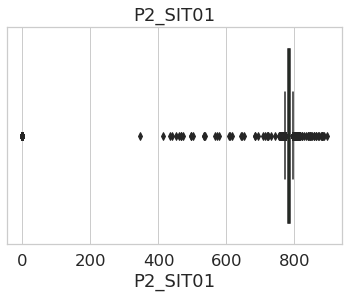

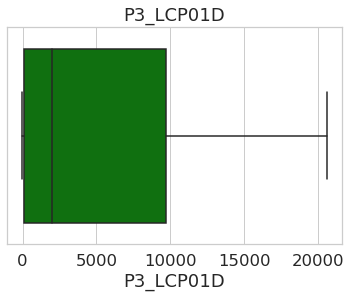

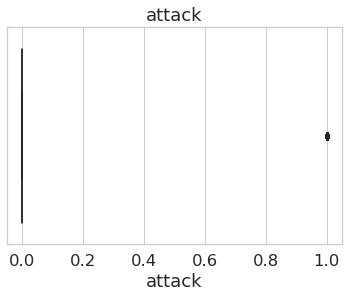

In [326]:
names=hai_data.columns
for name in names:
    _ = plt.figure(figsize=(6,4))
    _ = sns.boxplot(hai_data[name], color='green')
    _ = plt.title(name)
    plt.show()

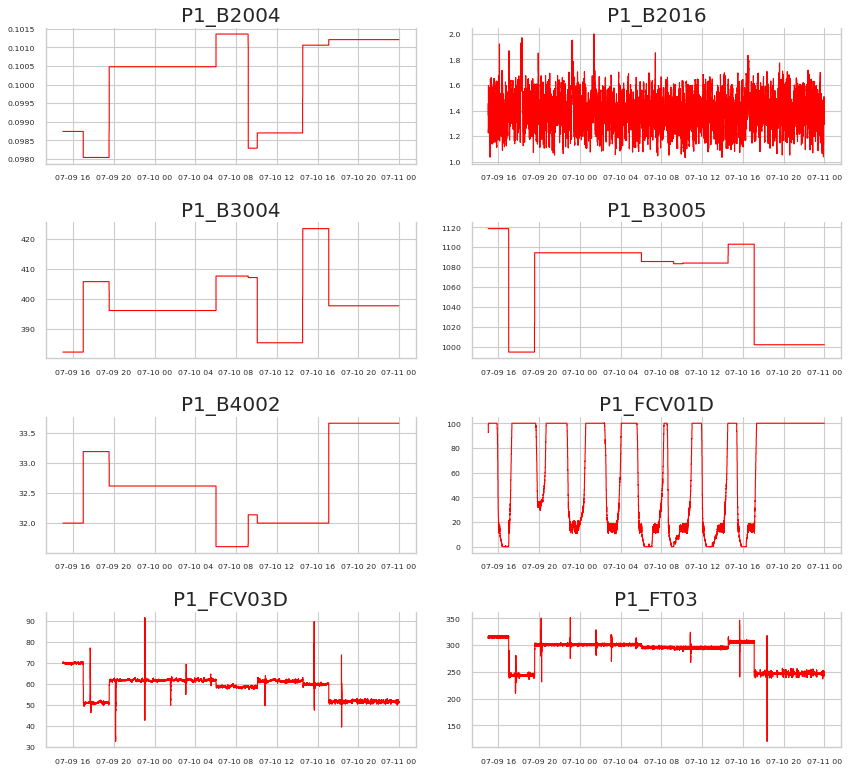

In [327]:
fig, axes = plt.subplots(nrows=4, ncols=2, dpi=80, figsize=(11,10))

for i, ax in enumerate(axes.flatten()):
    data = hai_data[hai_data.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(hai_data.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=7)
plt.tight_layout();

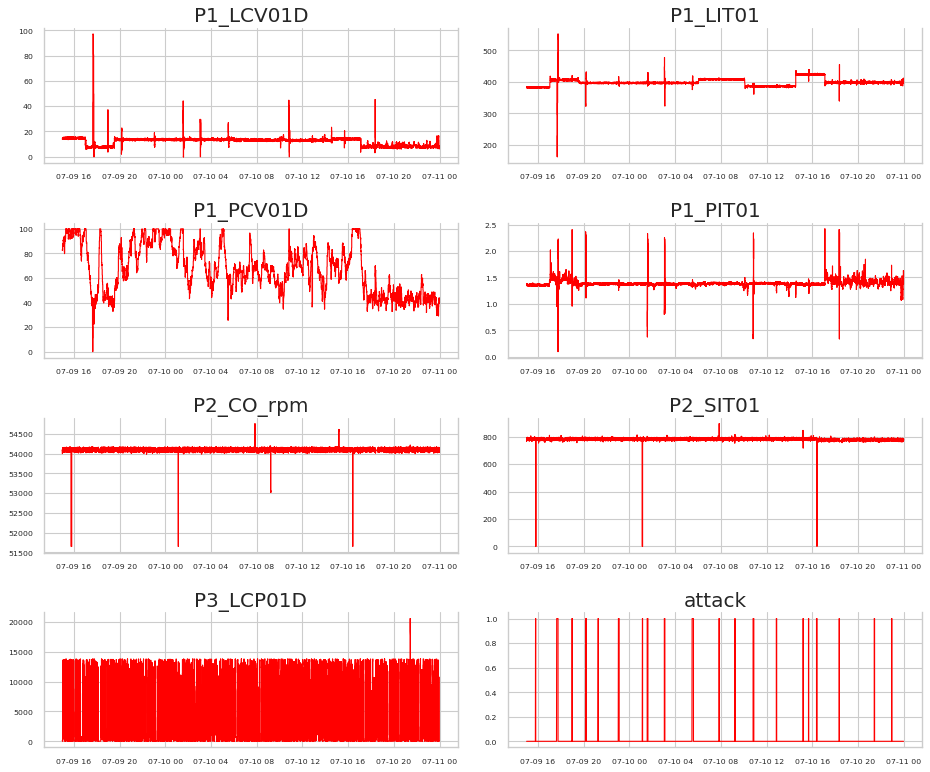

In [328]:
fig, axes = plt.subplots(nrows=4, ncols=2, dpi=80, figsize=(12,10))

for i, ax in enumerate(axes.flatten()):
    data = hai_data[hai_data.columns[i+8]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(hai_data.columns[i+8])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=7)
plt.tight_layout();

Text(0, 0.5, 'ICS dataset - Frequency Percentage')

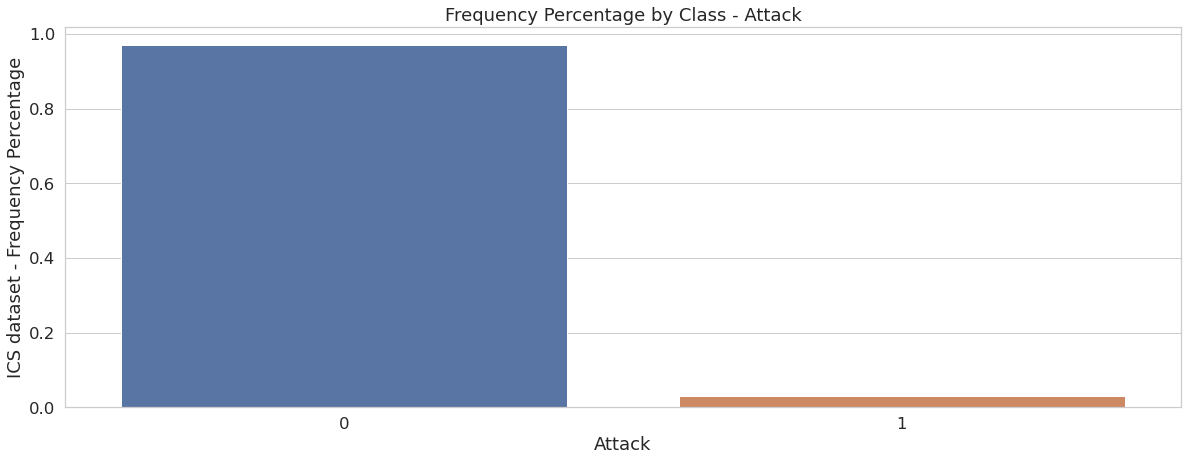

In [329]:
count_classes = pd.value_counts(hai_data['attack'],sort=True).sort_index()
ax = sns.barplot(x=count_classes.index, y=[tuple(count_classes/len(hai_data))[0],tuple(count_classes/len(hai_data))[1]])
ax.set_title('Frequency Percentage by Class - Attack')
ax.set_xlabel('Attack')
ax.set_ylabel('ICS dataset - Frequency Percentage')

### Correaltion
As part of exploratory data analysis sometimes incredibly useful to look at correlation matrix.
We look at heatmap based on our partition models to look closely in to the correlation between group with the similar types. We will start with the correlation matrix.
In the  plot below we can find negative and postitive correlation between each feature. The darker the color the close the feature correlated to the prediction goal.For example we find a positive correlation of 0.95 between P2_SIT01 & P2_CO_RPM  or between P1_B3005 and P1_FT03 .


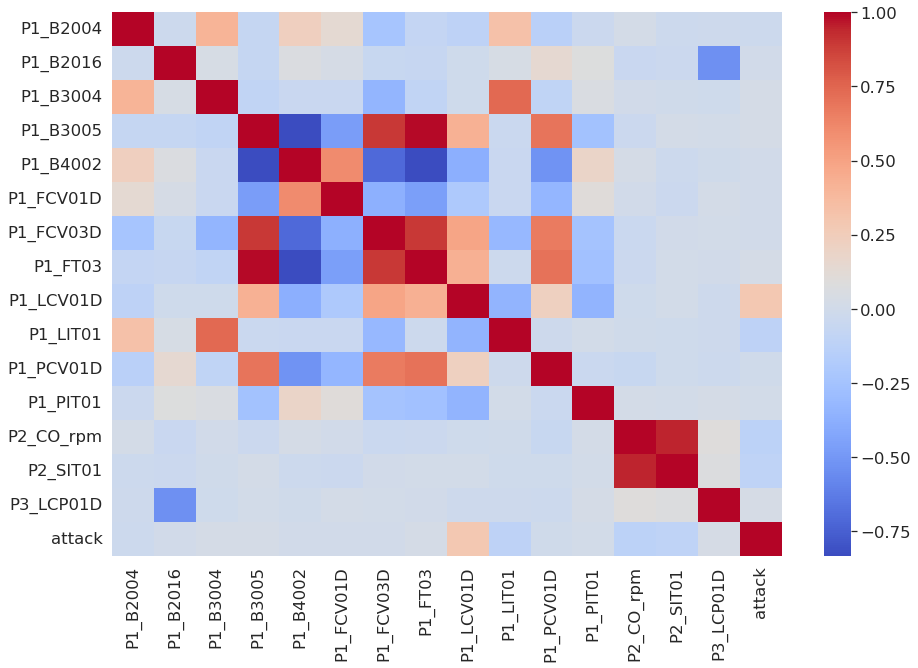

In [330]:
plt.figure(figsize=(15,10))
sns.heatmap(hai_data.corr(),annot=False,cmap='coolwarm')
plt.show()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

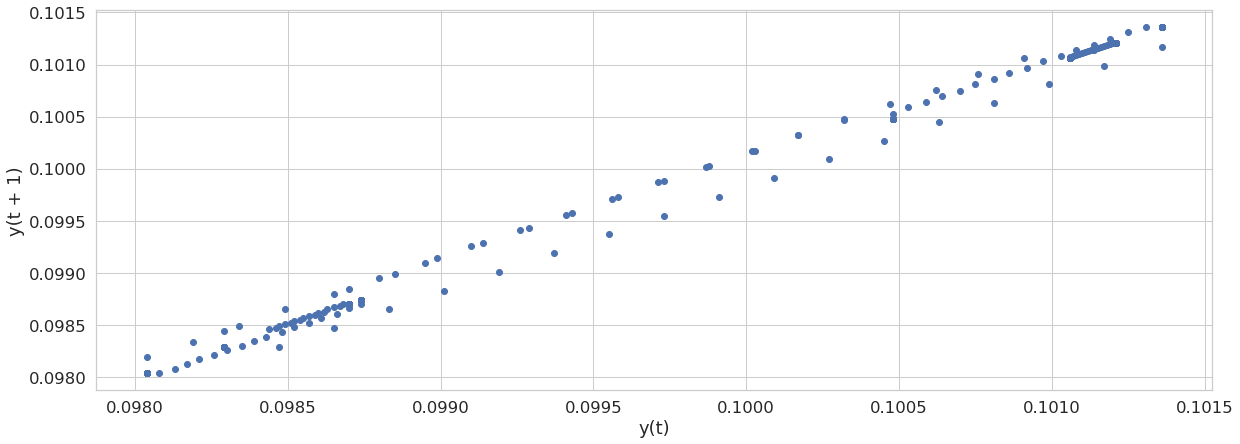

In [331]:
lag_plot(hai_data['P1_B2004'])

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


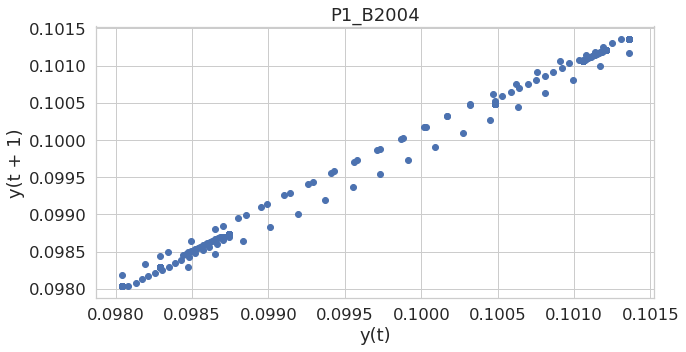

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


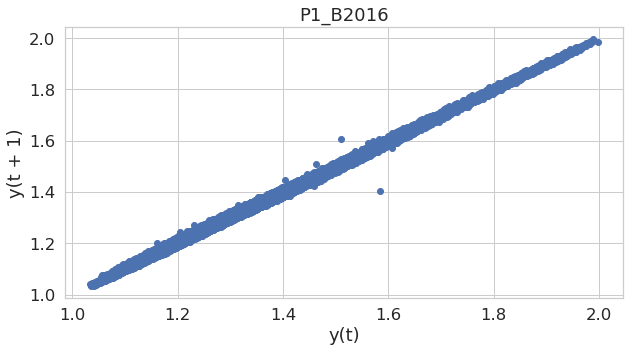

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


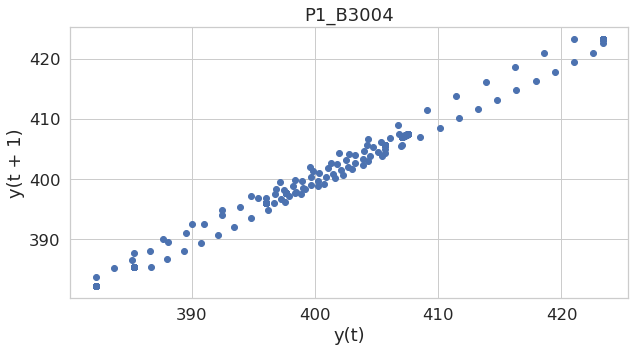

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


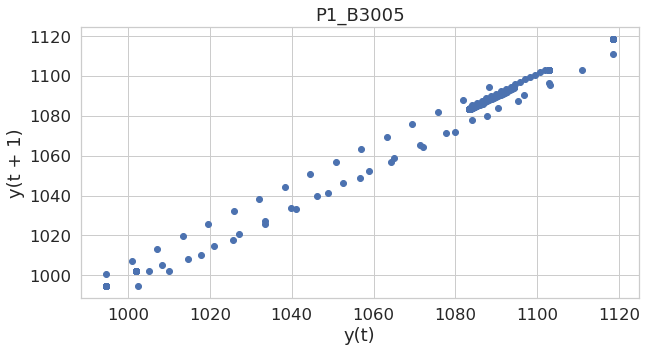

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


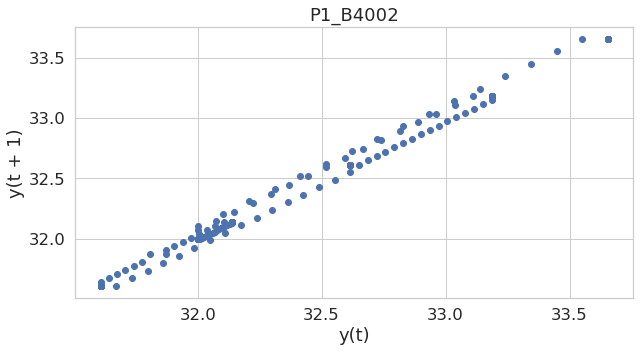

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


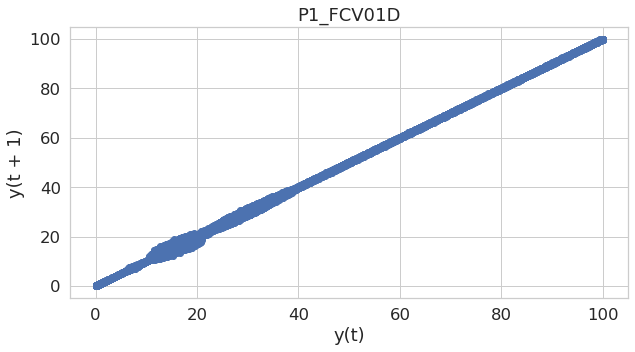

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


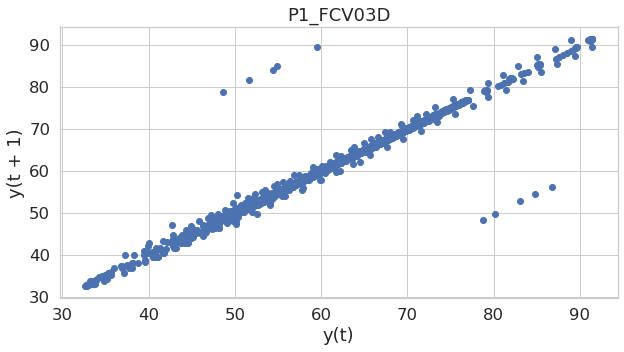

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


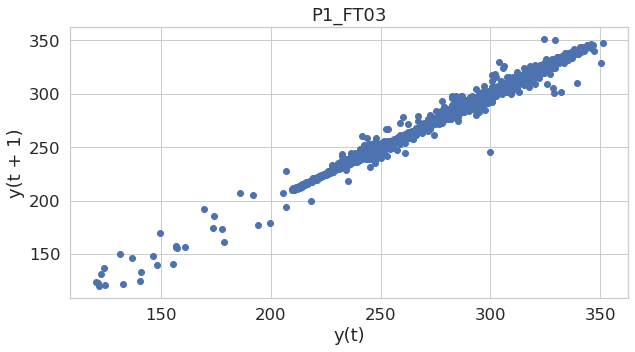

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


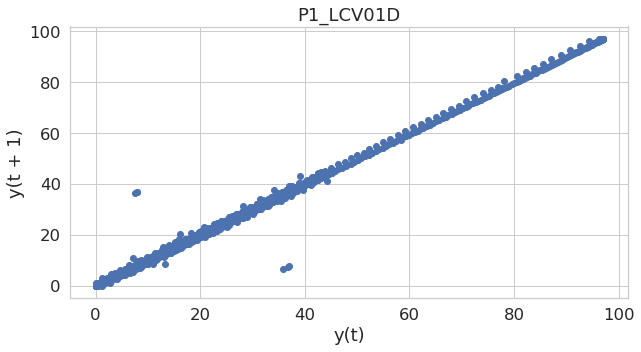

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


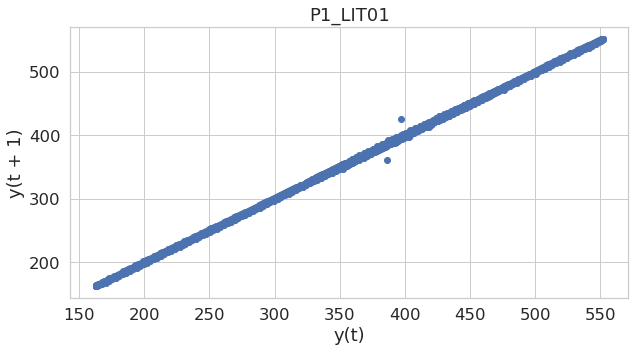

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


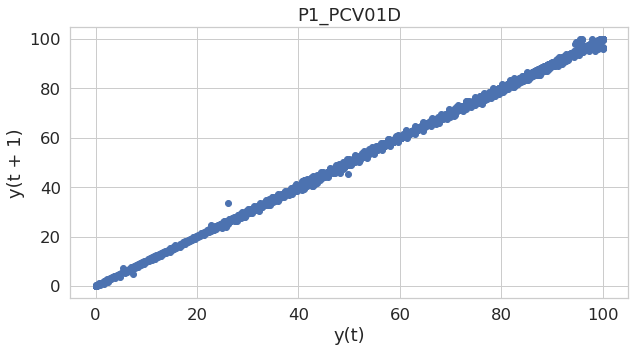

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


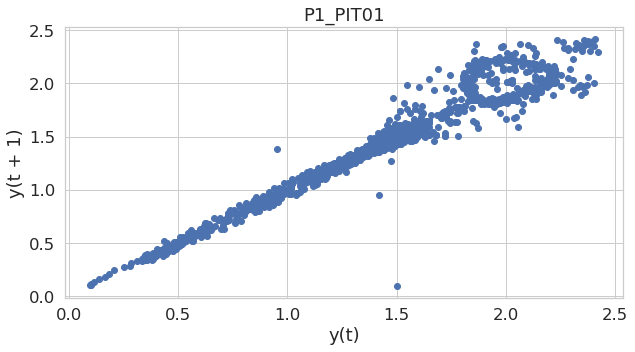

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


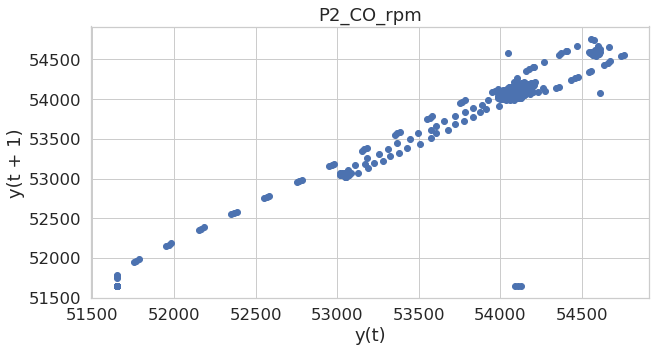

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


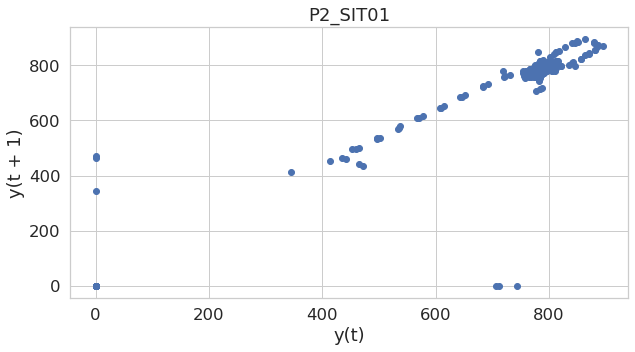

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


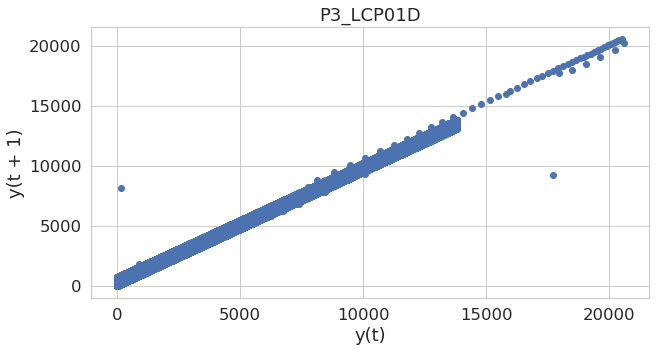

In [332]:
pred = hai_data.drop(['attack'], axis=1)
names=pred.columns
for name in names:
    _ = plt.figure(figsize=(10,5))
    _ = lag_plot(hai_data[name])
    _ = plt.title(name)
    #_ = plt.savefig('Trends'+str(name)+'.png')
    #plt.clf()
    plt.show()

Next we will plot the attacks on the sensors reading. The red marks, which represent the attack on the system, exactly overlap with the observed sensor reading irregularities, as seen in the above plot. We now have a solid idea of how each sensor reading behaves when attack or during abnormalities versus when it is working regularly or in the normal codition.

We did some additional graphical EDA on top of some quantitative EDA to check for trends and unusual behaviour. The sensor data plotted over time with the attack status of <b>"1" </b> put up in red on the same graph is really interesting.

That way, we can see exactly when the attack occured or any abnormalities and how the sensor values reflect it. The following code generates the aforementioned graph for each of the sensors/ setpoints reading :

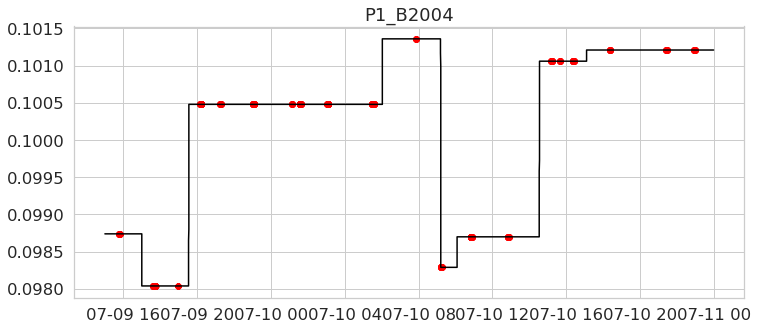

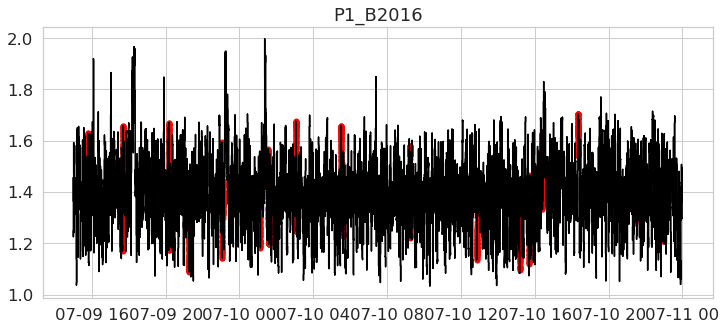

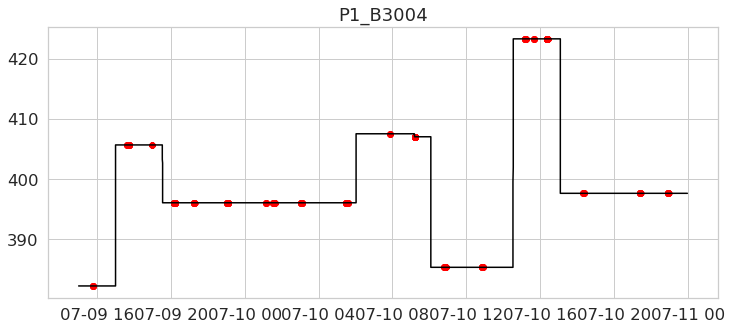

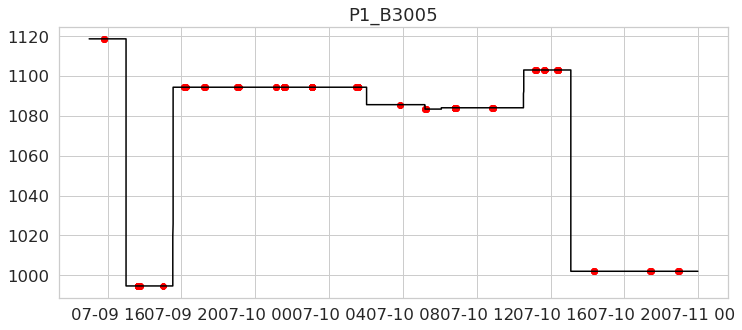

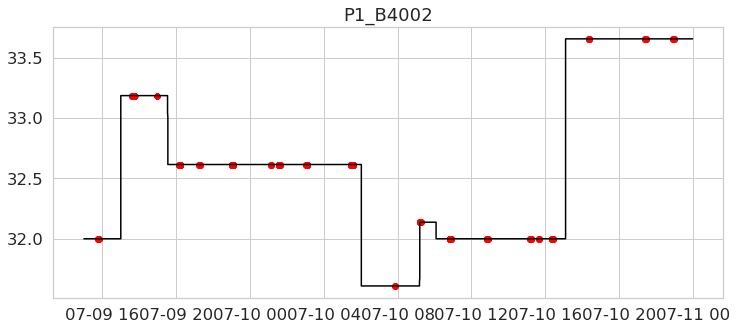

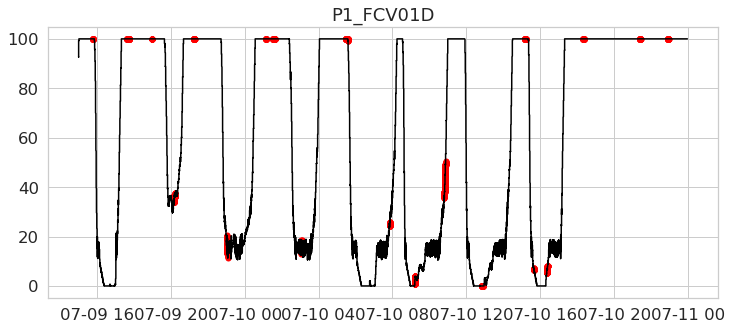

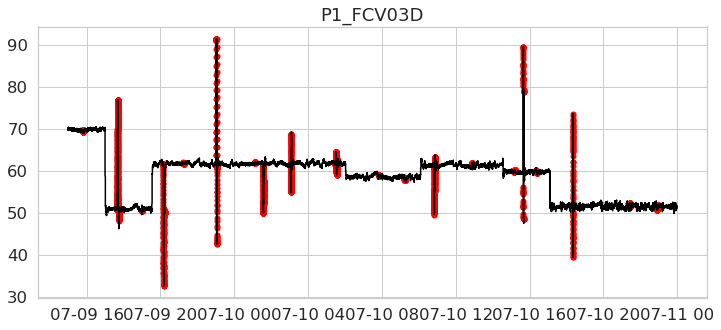

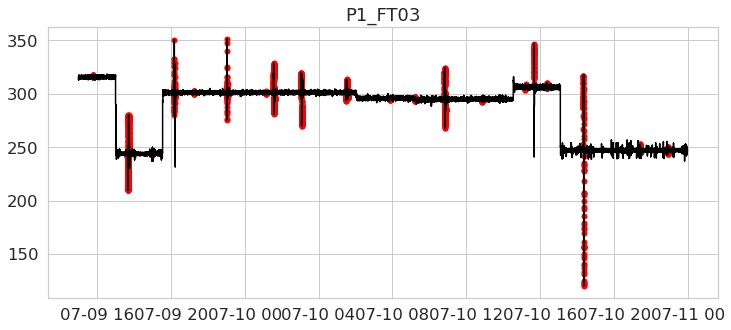

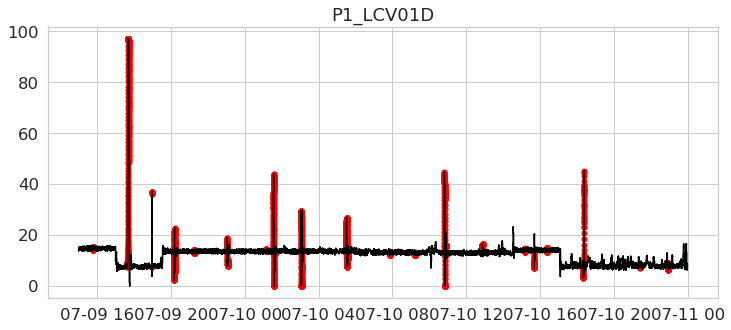

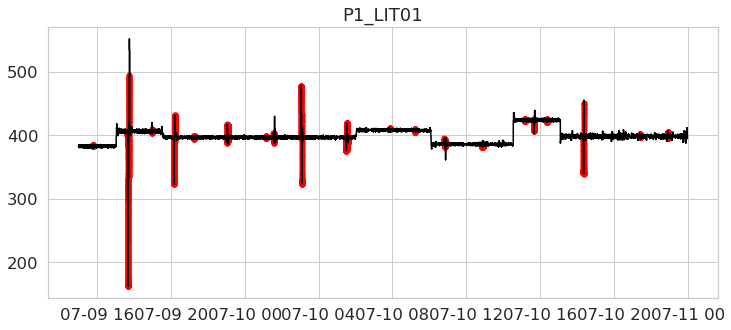

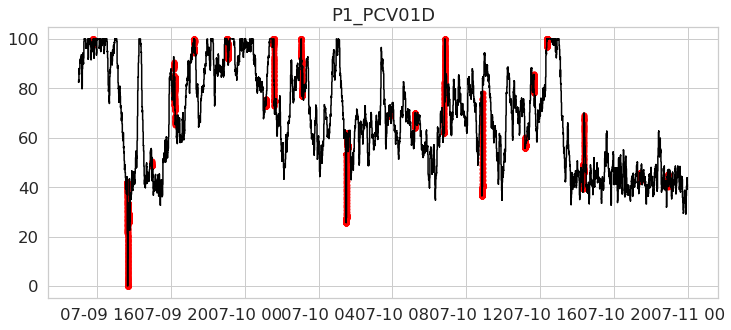

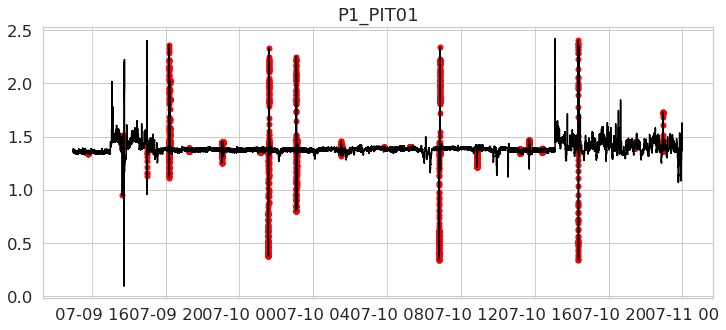

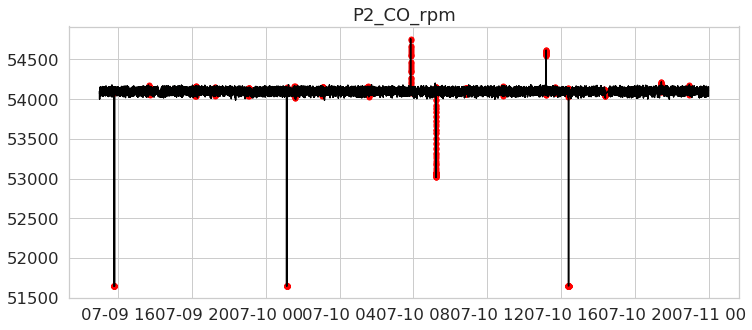

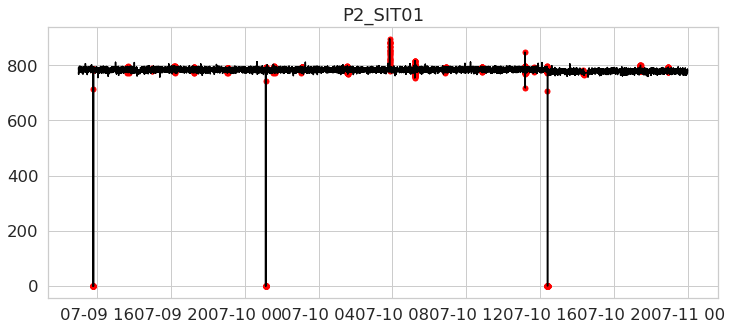

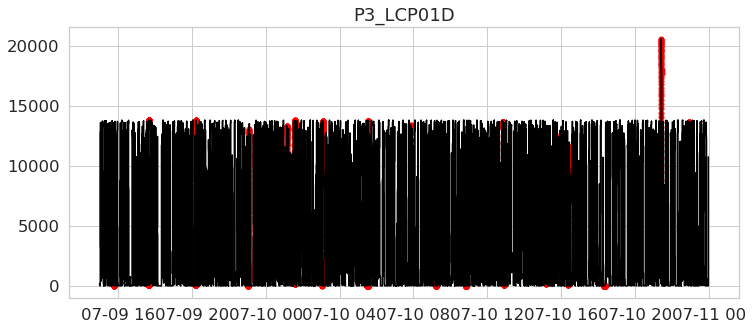

In [333]:
attck_state = hai_data[hai_data['attack'] == 1]
pred = hai_data.drop(['attack'], axis=1)
names=pred.columns
for name in names:
    _ = plt.figure(figsize=(12,5))
    _ = plt.plot(attck_state[name], linestyle='none', marker='o', color='red', markersize=5)
    _ = plt.plot(hai_data[name], color='black')
    _ = plt.title(name)
    #_ = plt.savefig('Trends'+str(name)+'.png')
    #plt.clf()
    plt.show()

### Resample The Data (5T - 5 Minutes)
To simplify our plots which has a lot of data points due to the hourly and minute records, we can aggregate the data for each day using the .resample() method.

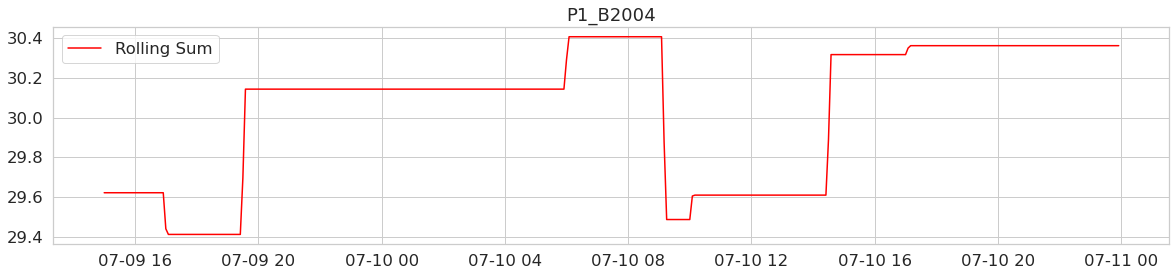

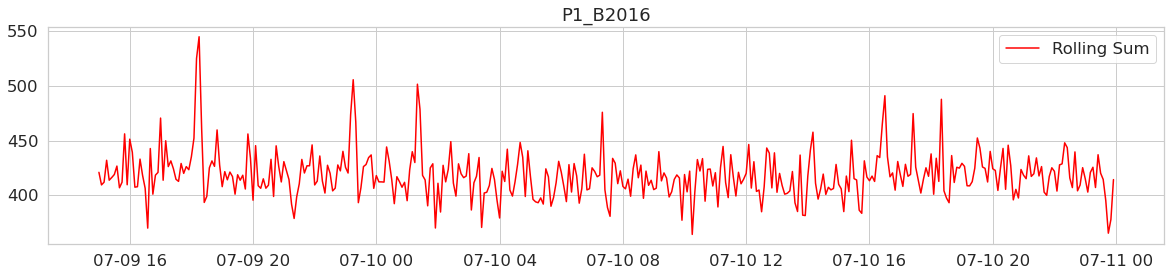

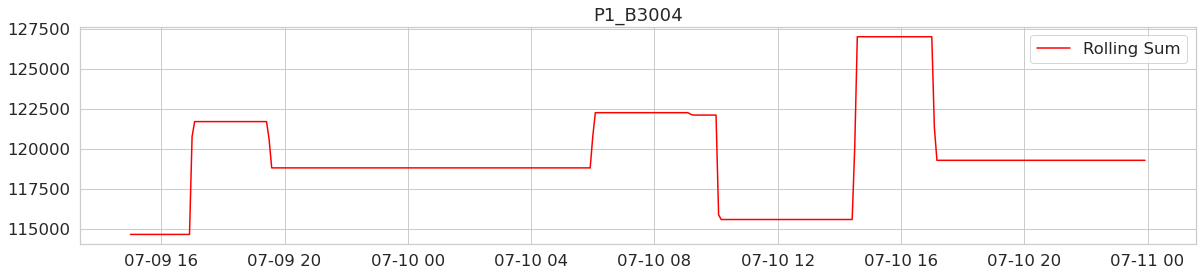

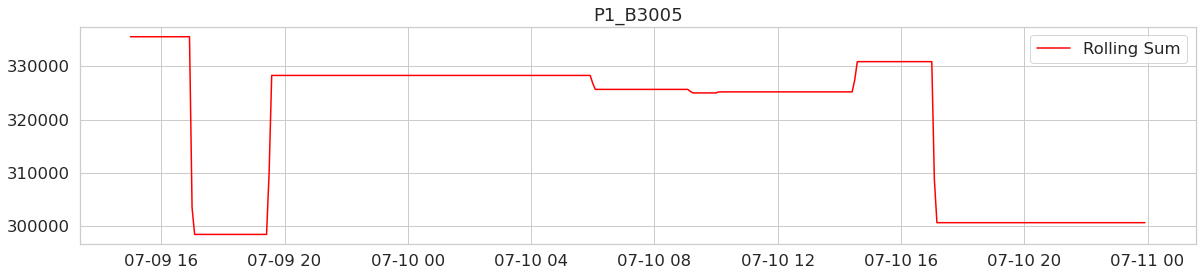

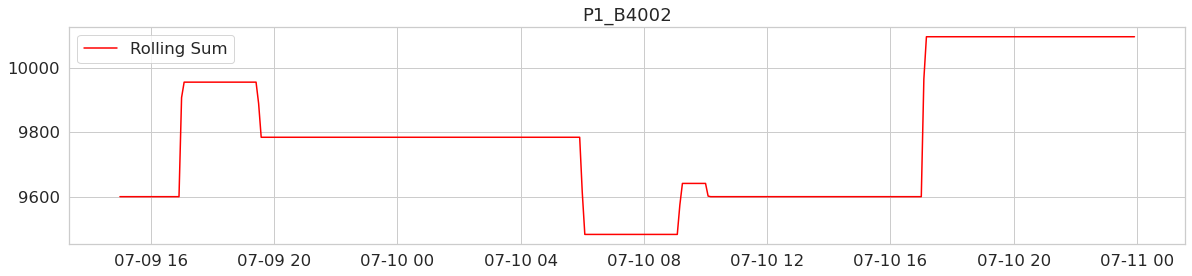

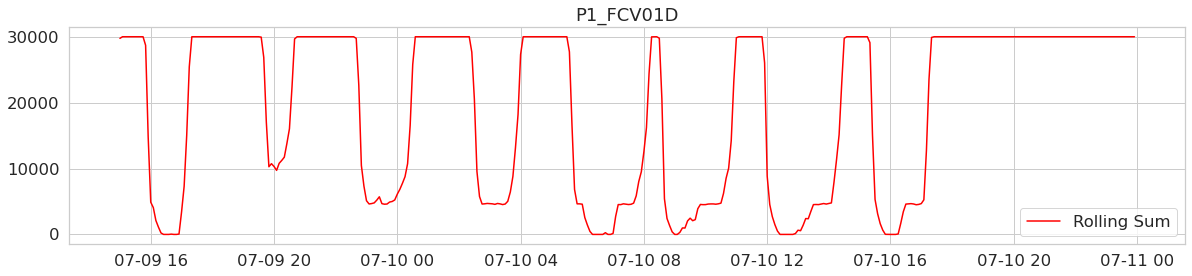

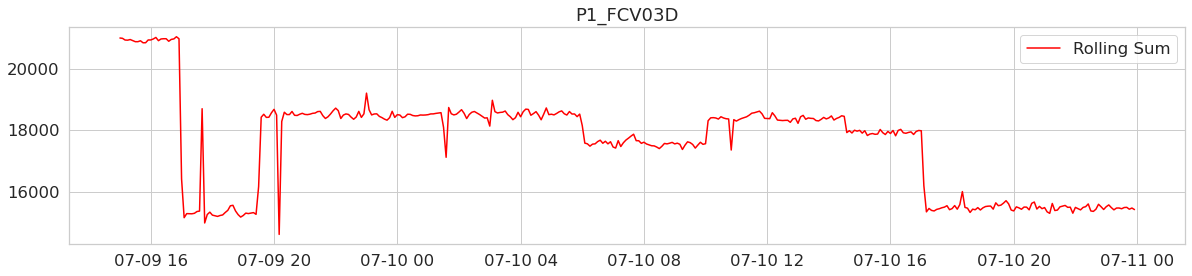

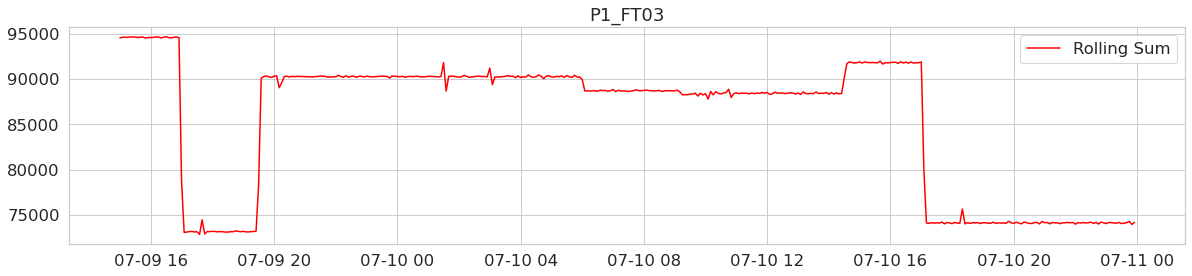

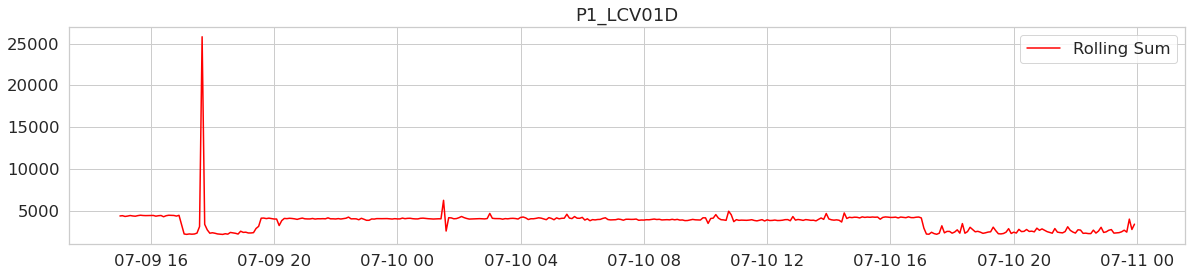

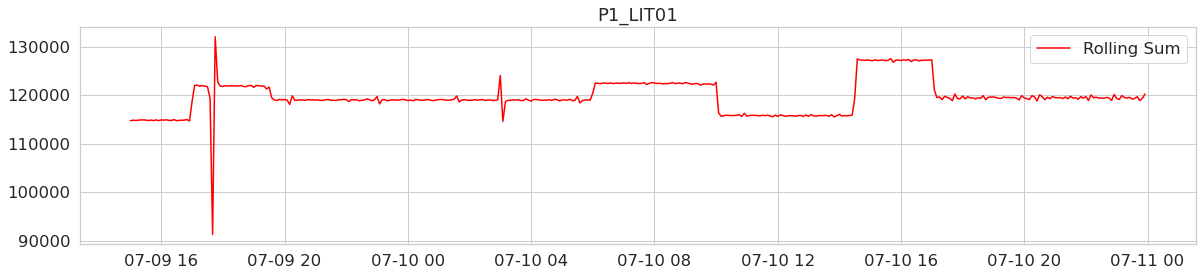

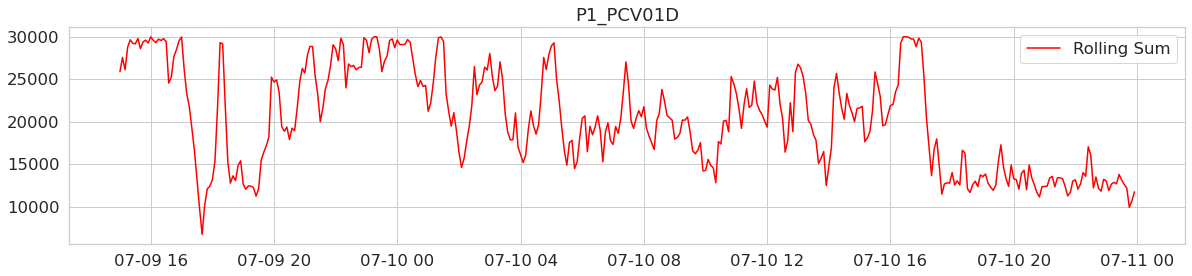

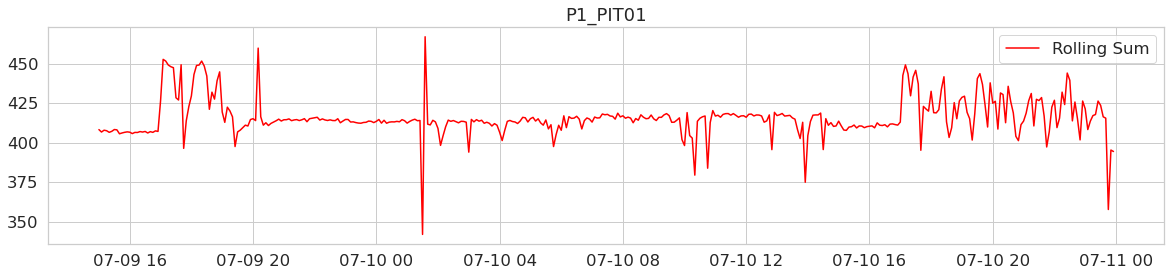

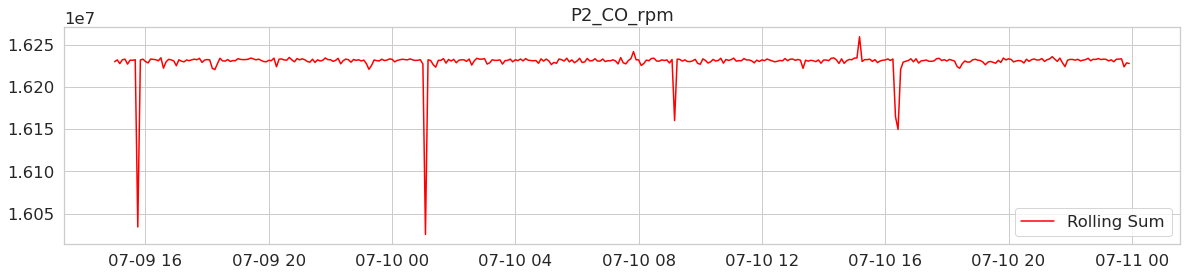

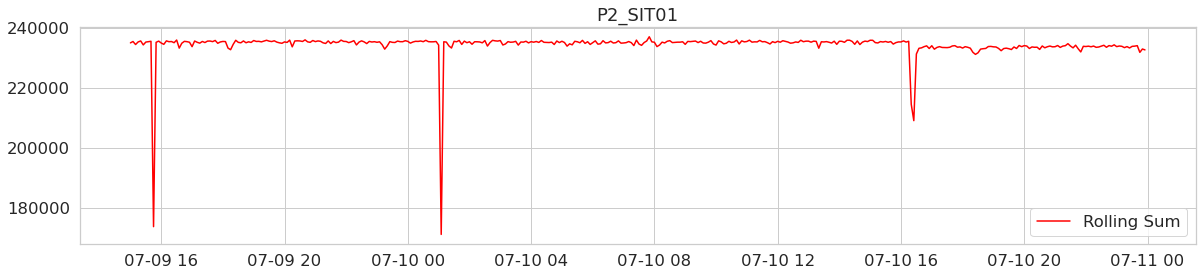

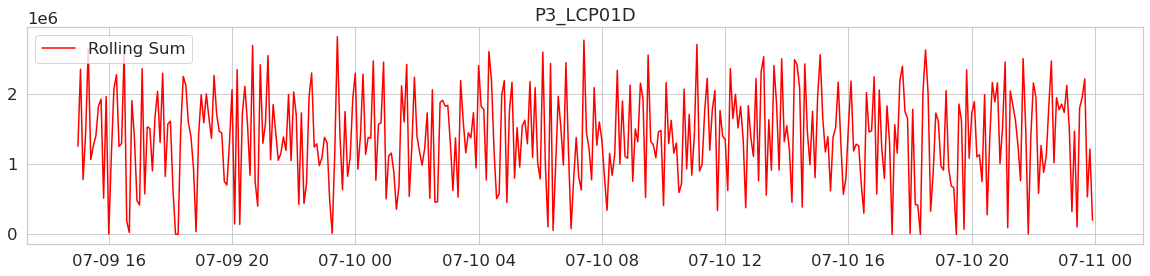

In [334]:
# Resample the entire dataset by 5 minutes average
rollsum = hai_data.resample(rule='5T').sum()

# Plot time series for each sensor with its mean and standard deviation
for name in names:
    _ = plt.figure(figsize=(20,4))
    _ = plt.plot(rollsum[name], color='red', label='Rolling Sum' )
    _ = plt.legend(loc='best')
    _ = plt.title(name)
    plt.show()

showing the observation for the time mentioned above

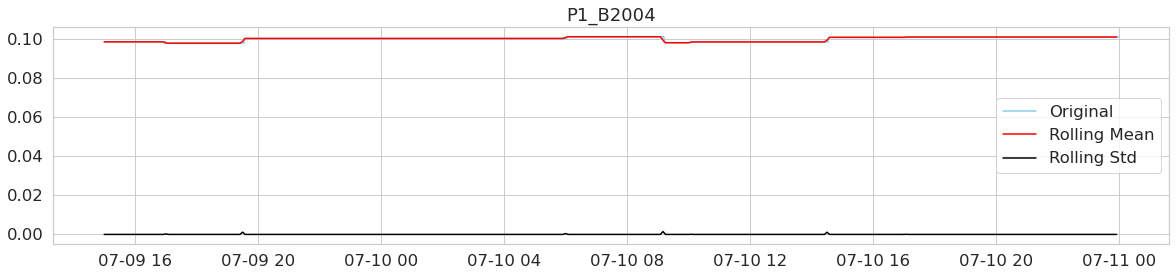

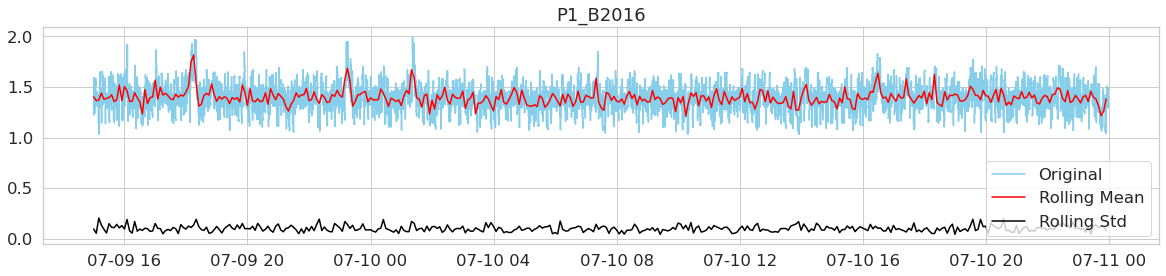

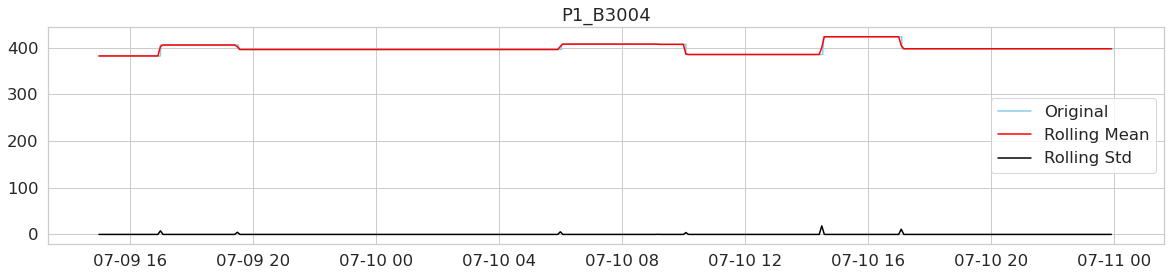

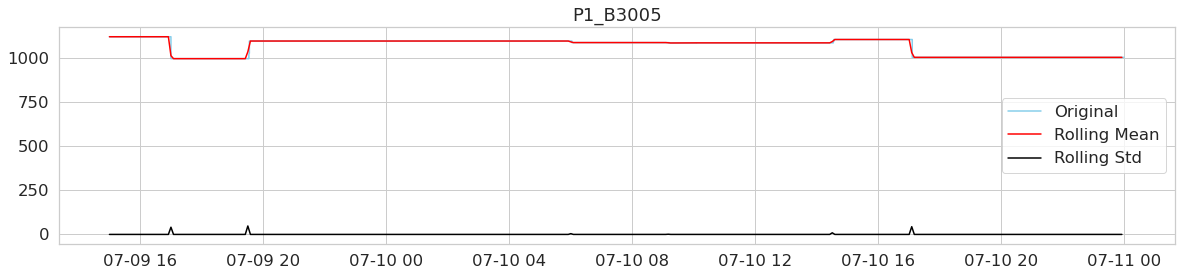

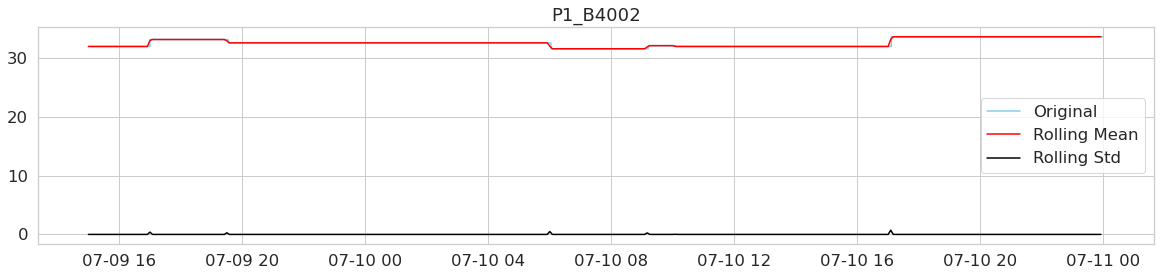

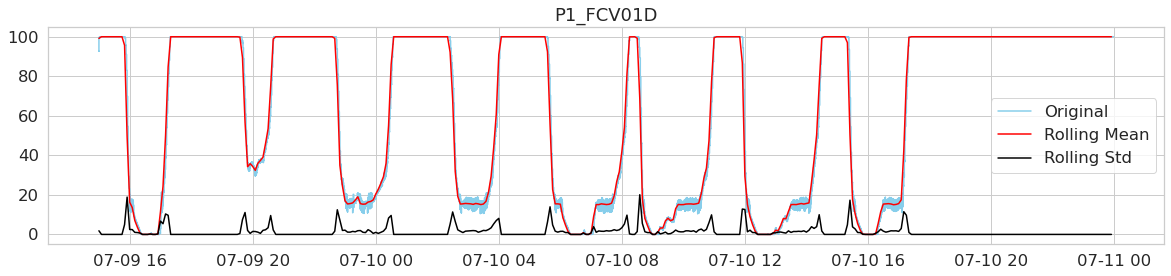

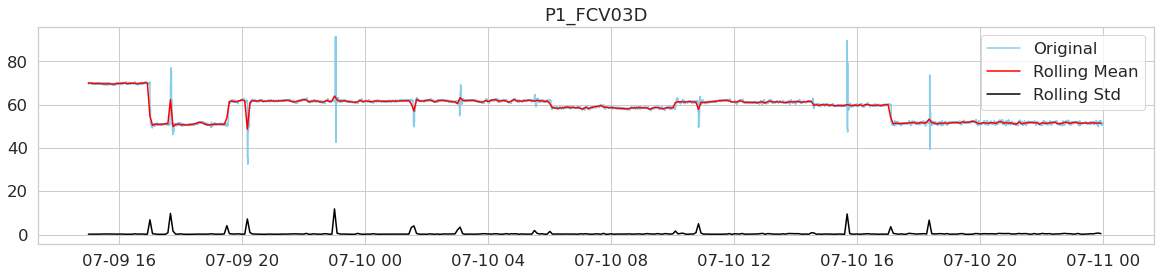

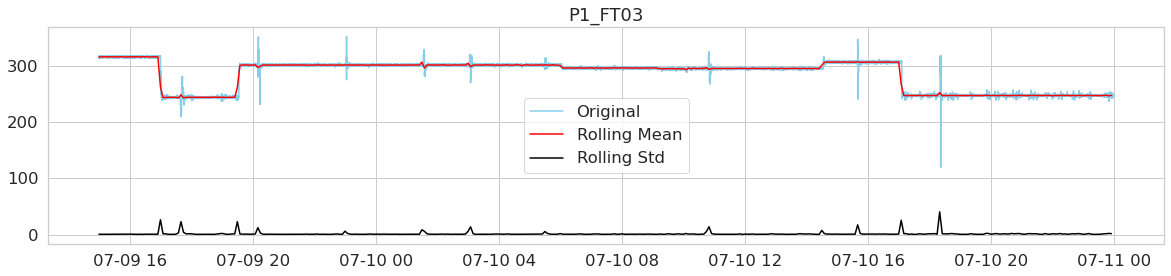

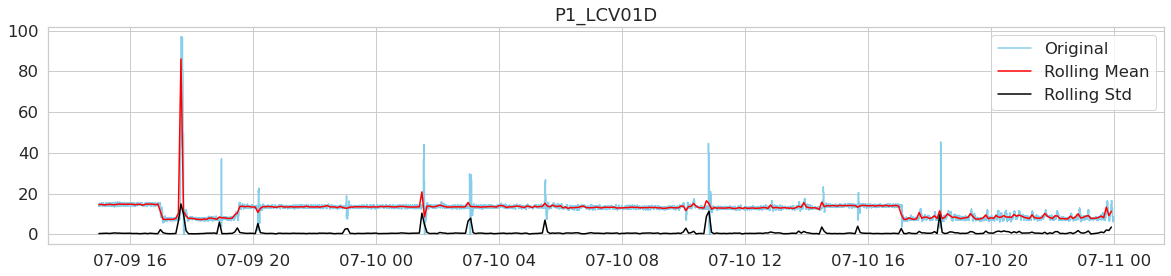

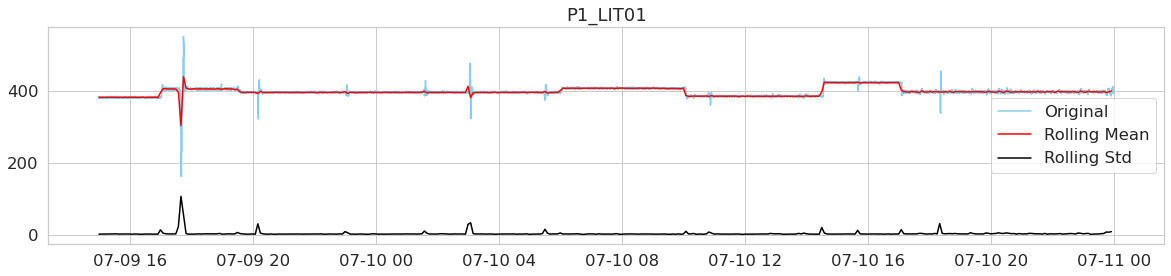

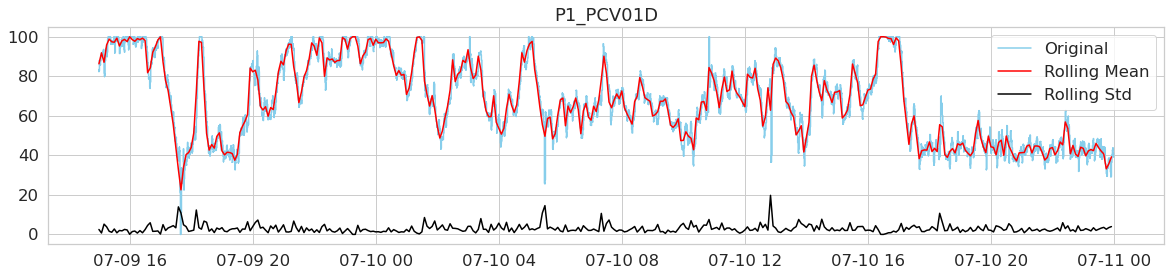

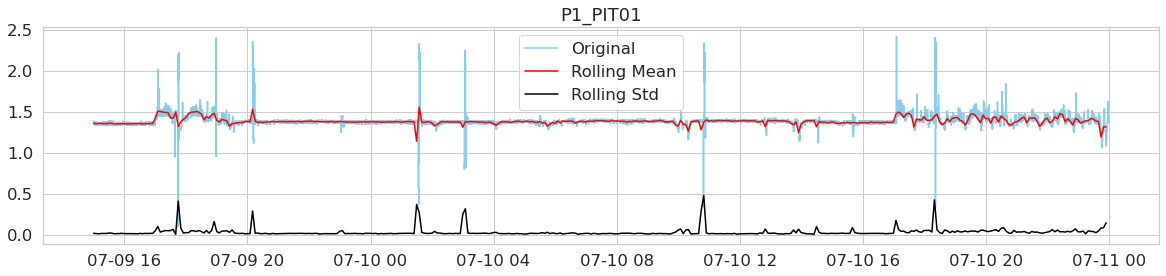

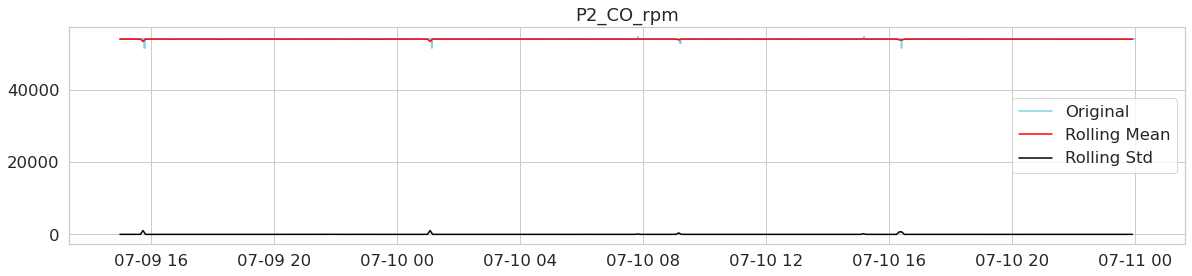

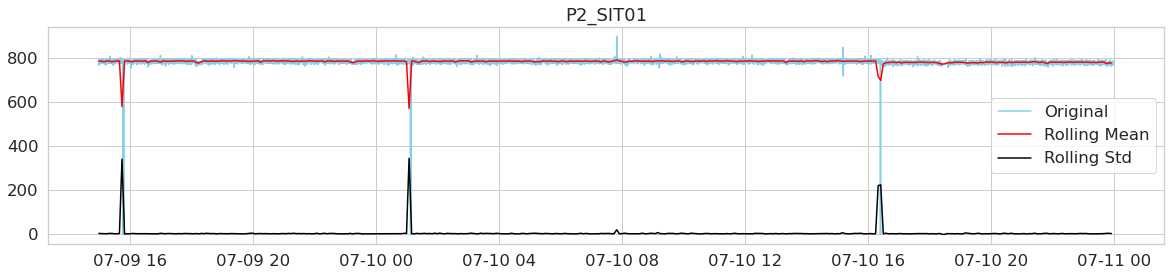

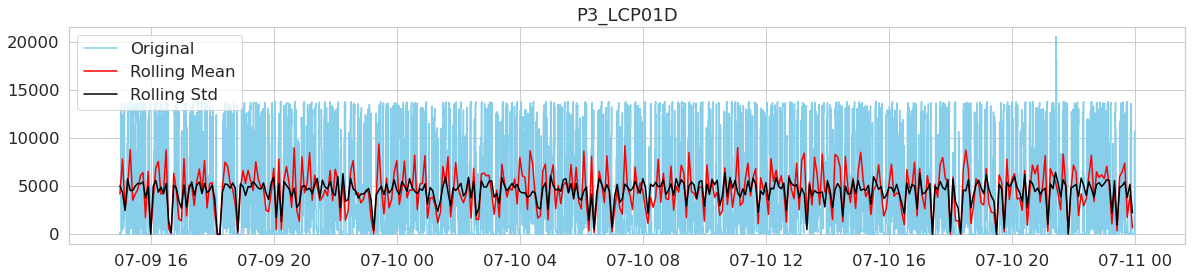

In [335]:
# Resample the entire dataset by 5 minutes average
rollmean = hai_data.resample(rule='5T').mean()
rollstd = hai_data.resample(rule='5T').std()
# Plot time series for each sensor with its mean and standard deviation
for name in names:
    _ = plt.figure(figsize=(20,4))
    _ = plt.plot(hai_data[name], color='skyblue', label='Original')
    _ = plt.plot(rollmean[name], color='red', label='Rolling Mean')
    _ = plt.plot(rollstd[name], color='black', label='Rolling Std' )
    _ = plt.legend(loc='best')
    _ = plt.title(name)
    plt.show()

As seen from the plots above we conclude the followins:

Prominent seasonality can be observed in series
Noticeable trends and changing levels can be seen in series P1_B2004 ,P1_B3004 , P1FCV03D also shows increasing variance.
Some of the data here are stationary and others not so we will need to apply a transformation method on the data to make the data stationary before training the data.

### Time Series Decomposition

Decomposing a time series entails seeing it as a collection of level, trend, seasonality, and noise components.
Decomposition is a helpful abstract paradigm for thinking about time series in general, as well as for better comprehending challenges encountered during time series analysis and forecasting.

A given time series is thought to consist of three systematic components including level, trend, seasonality, and one non-systematic component called noise.

These components are defined as follows:

* Level: The average value in the series. rises and falls that are not of a fixed frequency - cyclic variations.
* Trend: The increasing or decreasing value in the series. presense of long-term increase or decrease in the sequence.
* Seasonality: The repeating short-term cycle in the series. variation that occurs at specific intervals of less than a year - span (daily, weekly, monthly).
* Noise: The random variation in the series.

### Causality Check 

A better way of checking the correlation between variables is using the Granger's causality check. 

In [338]:
maxlag = 10
test = 'ssr_chi2test'
def grangers_causality_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causality_matrix(hai_data, variables = hai_data.columns) 

P1_B2004_x  P1_B2016_x  P1_B3004_x  P1_B3005_x  P1_B4002_x  \
P1_B2004_y       1.0000      0.0001      0.0000      0.0000      0.0000   
P1_B2016_y       0.0000      1.0000      0.0000      0.0063      0.0000   
P1_B3004_y       0.0000      0.0434      1.0000      0.0000      0.0000   
P1_B3005_y       0.0000      0.5409      0.0000      1.0000      0.0000   
P1_B4002_y       0.0000      0.0000      0.0041      0.0000      1.0000   
P1_FCV01D_y      0.0001      0.0000      0.1185      0.0000      0.0000   
P1_FCV03D_y      0.0004      0.0915      0.0002      0.0000      0.0000   
P1_FT03_y        0.0000      0.0093      0.0506      0.0000      0.0000   
P1_LCV01D_y      0.0000      0.0000      0.0000      0.0000      0.0000   
P1_LIT01_y       0.0000      0.0000      0.0000      0.0000      0.0000   
P1_PCV01D_y      0.0000      0.0000      0.0000      0.0000      0.0000   
P1_PIT01_y       0.0599      0.0000      0.0000      0.0000      0.0000   
P2_CO_rpm_y      0.4896      0.0000      0.7642      0.1656      0.3893   
P2_SIT01_y       0.4208      0.0000      0.8233      0.0264      0.2892   
P3_LCP01D_y      0.4493      0.0000      0.8654      0.8425      0.9373   
attack_y         0.5751      0.4805      0.6769      0.6829      0.9918   

             P1_FCV01D_x  P1_FCV03D_x  P1_FT03_x  P1_LCV01D_x  P1_LIT01_x  \
P1_B2004_y        0.0000       0.0377     0.0000       0.3755      0.0930   
P1_B2016_y        0.0139       0.1133     0.0217       0.0000      0.0000   
P1_B3004_y        0.0346       0.0000     0.0099       0.0000      0.0000   
P1_B3005_y        0.0000       0.0000     0.0000       0.7535      0.3739   
P1_B4002_y        0.0000       0.0000     0.0000       0.6565      0.0012   
P1_FCV01D_y       1.0000       0.0000     0.0000       0.0000      0.2964   
P1_FCV03D_y       0.0013       1.0000     0.0000       0.0000      0.0000   
P1_FT03_y         0.0555       0.0000     1.0000       0.0000      0.0000   
P1_LCV01D_y       0.1912       0.0000     0.0000       1.0000      0.0000   
P1_LIT01_y        0.6939       0.0000     0.0000       0.0000      1.0000   
P1_PCV01D_y       0.5926       0.0000     0.0000       0.0000      0.0000   
P1_PIT01_y        0.0012       0.0000     0.0000       0.0000      0.0000   
P2_CO_rpm_y       0.9241       0.1086     0.1469       0.3699      0.4014   
P2_SIT01_y        0.3558       0.8076     0.7383       0.7892      0.6607   
P3_LCP01D_y       0.1050       0.0765     0.3959       0.0000      0.0000   
attack_y          0.9271       0.0000     0.0000       0.0000      0.0008   

             P1_PCV01D_x  P1_PIT01_x  P2_CO_rpm_x  P2_SIT01_x  P3_LCP01D_x  \
P1_B2004_y        0.0007      0.0307       0.3554      0.4589       0.0117   
P1_B2016_y        0.0000      0.0000       0.0000      0.0000       0.0000   
P1_B3004_y        0.0506      0.0003       0.4214      0.6790       0.3880   
P1_B3005_y        0.0000      0.0019       0.0988      0.6387       0.0077   
P1_B4002_y        0.0000      0.0132       0.0250      0.6488       0.3024   
P1_FCV01D_y       0.2981      0.0000       0.4892      0.5551       0.0928   
P1_FCV03D_y       0.0000      0.0060       0.8634      0.6920       0.0820   
P1_FT03_y         0.0000      0.0000       0.2900      0.6308       0.2172   
P1_LCV01D_y       0.0000      0.0000       0.0347      0.2160       0.0000   
P1_LIT01_y        0.0000      0.0000       0.0284      0.0555       0.0000   
P1_PCV01D_y       1.0000      0.0000       0.0000      0.0048       0.0000   
P1_PIT01_y        0.0000      1.0000       0.3336      0.7454       0.0013   
P2_CO_rpm_y       0.0000      0.1627       1.0000      0.0000       0.0000   
P2_SIT01_y        0.1279      0.3868       0.0000      1.0000       0.0000   
P3_LCP01D_y       0.0000      0.0000       0.0000      0.0000       1.0000   
attack_y          0.0000      0.0047       0.0000      0.0000       0.2506   

             attack_x  
P1_B2004_y     0.6972  
P1_B2016_y     0.4152  
P1_B3004_y     0.8806  
P1_B

In [339]:
nobs = 35400   # 30 % 70%
hai_train, hai_test = hai_data[0:-nobs], hai_data[-nobs:]
# Check size  
print(hai_train.shape) 
print(hai_test.shape)

(83400, 16)
(35400, 16)


### Autocorrelation and Stationarity Check

It is critical in time series analysis that the data be steady and free of autocorrelation. The term "stationarity" refers to the behavior of data whose mean and standard deviation change over time; data with this behavior is not considered stationary. 
<br>
Autocorrelation, on the other hand, is the behavior of data when it is correlated with itself at a different time period. 
<br>
Next, I'll  do the followings :
1. visually evaluate the stationarity of each feature in the data set, which is exactly what the following code will accomplish. 
2. Use Dickey Fuller test to quantitatively confirm the observed stationarity later.
<br>
3. We'll also look at the autocorrelation of the characteristics before feeding them into the clustering algorithms to see if there are any irregularities.

In [340]:
def stationarity_check(data, column='', signif=0.05, series=False):
    if series:
        adf_test = adfuller(data, autolag='AIC')
    else:
        adf_test = adfuller(data[column], autolag='AIC')
    p_value = adf_test[1]
    if p_value <= signif:
        test_result = "Stationary"
    else:
        test_result = "Non-Stationary"
    return test_result

adf_test_results = {col: stationarity_check(hai_data, col)for col in hai_data.columns}
adf_test_results

{'P1_B2004': 'Non-Stationary',
 'P1_B2016': 'Stationary',
 'P1_B3004': 'Stationary',
 'P1_B3005': 'Non-Stationary',
 'P1_B4002': 'Non-Stationary',
 'P1_FCV01D': 'Stationary',
 'P1_FCV03D': 'Stationary',
 'P1_FT03': 'Stationary',
 'P1_LCV01D': 'Stationary',
 'P1_LIT01': 'Stationary',
 'P1_PCV01D': 'Stationary',
 'P1_PIT01': 'Stationary',
 'P2_CO_rpm': 'Stationary',
 'P2_SIT01': 'Stationary',
 'P3_LCP01D': 'Stationary',
 'attack': 'Stationary'}

### Make the data stationary 
The Augmented Dickey-Fuller Technique is a popular statistical test for determining whether or not a time series is stationary. This can be accomplished by specifying the null and alternate hypotheses.
* Null Hypothesis: Time Series is stationary. It gives a time-dependent trend.
* Alternate Hypothesis: Time Series is non-stationary. In another term, the series doesn’t depend on time.
* ADF or t Statistic < critical values: Accept the null hypothesis. Time series is stationary.
* ADF or t Statistic > critical values: Failed to reject the null hypothesis. The time series is non-stationary

We have run the ADF test for every column in the data.
We convert the data to stationary if it is not stationary using differencing

In [341]:
# Differencing  Function
def differencing(data, column, order):
    differenced_data = data[column].diff(order)
    differenced_data.fillna(differenced_data.mean(), inplace=True)
    return differenced_data


In [342]:
# Iterate through the columns
hai_data_diff = pd.DataFrame()
for col in hai_data.columns:
    hai_data_diff[col] = differencing(hai_data, col, 1)

# Running the stationary check again
adf_test_results = {col: stationarity_check(hai_data_diff, col)for col in hai_data_diff.columns}

# Stationary results
adf_test_results

{'P1_B2004': 'Stationary',
 'P1_B2016': 'Stationary',
 'P1_B3004': 'Stationary',
 'P1_B3005': 'Stationary',
 'P1_B4002': 'Stationary',
 'P1_FCV01D': 'Stationary',
 'P1_FCV03D': 'Stationary',
 'P1_FT03': 'Stationary',
 'P1_LCV01D': 'Stationary',
 'P1_LIT01': 'Stationary',
 'P1_PCV01D': 'Stationary',
 'P1_PIT01': 'Stationary',
 'P2_CO_rpm': 'Stationary',
 'P2_SIT01': 'Stationary',
 'P3_LCP01D': 'Stationary',
 'attack': 'Stationary'}

The first differencing produced stationary data which is what needed for  modeling

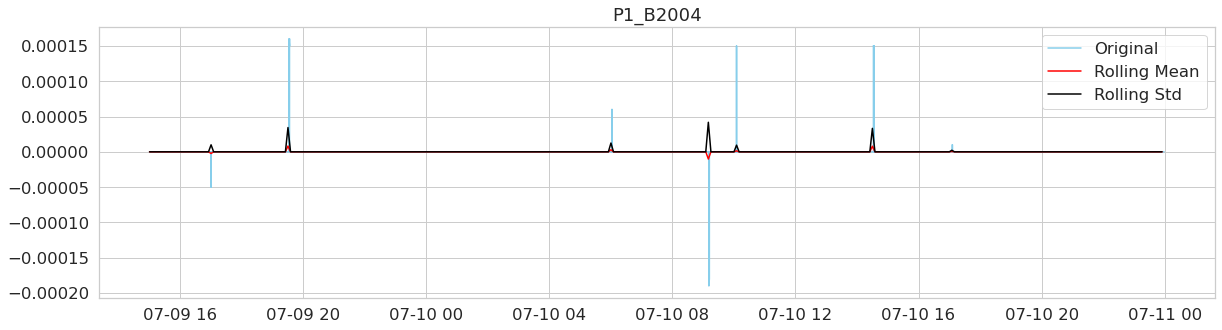

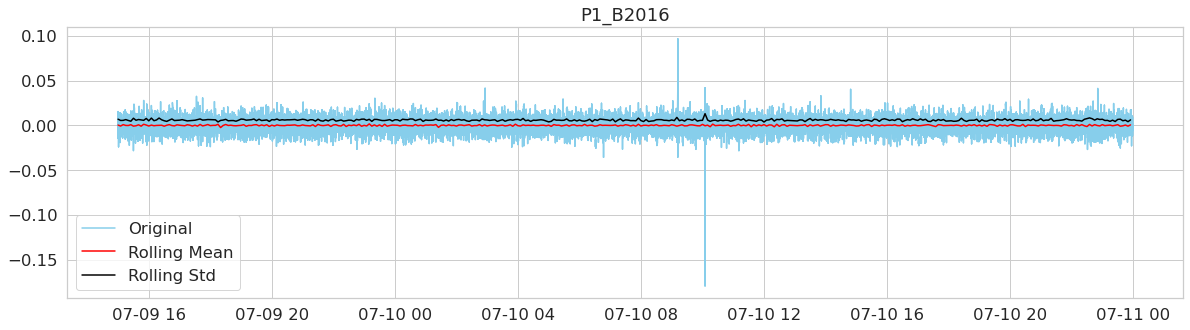

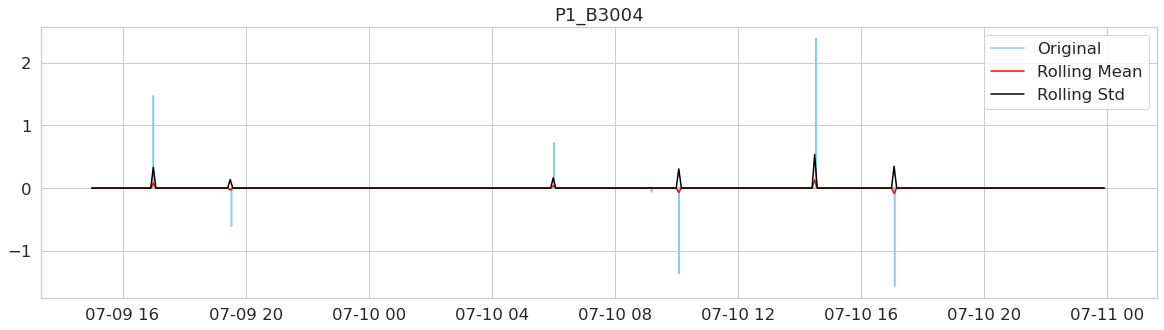

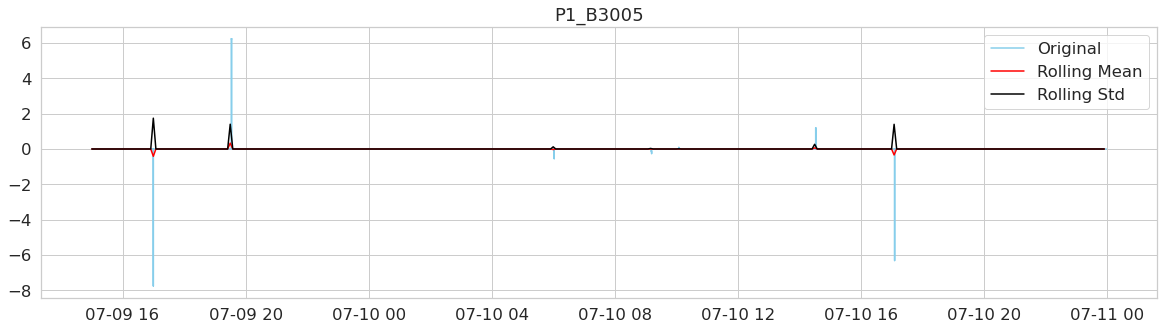

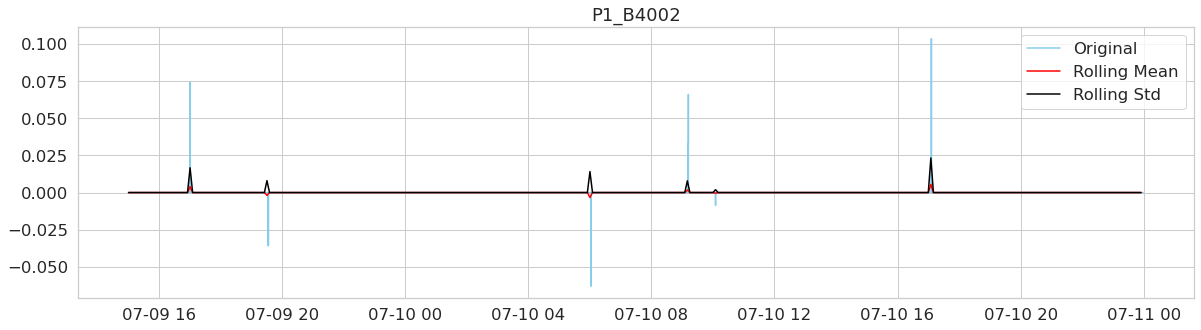

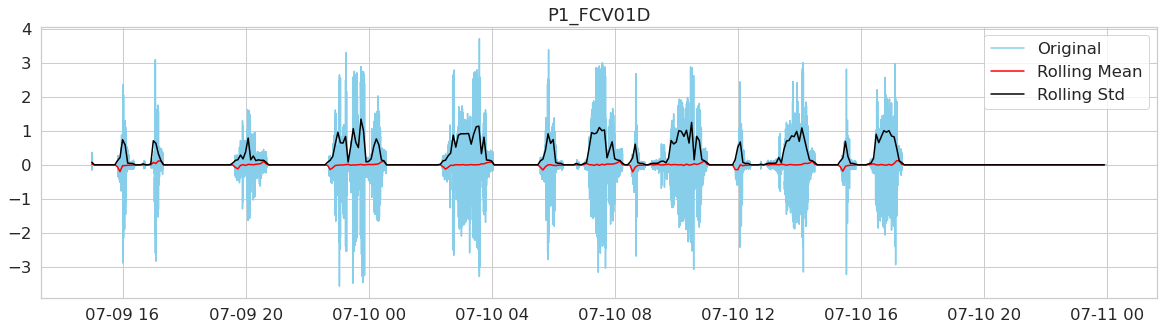

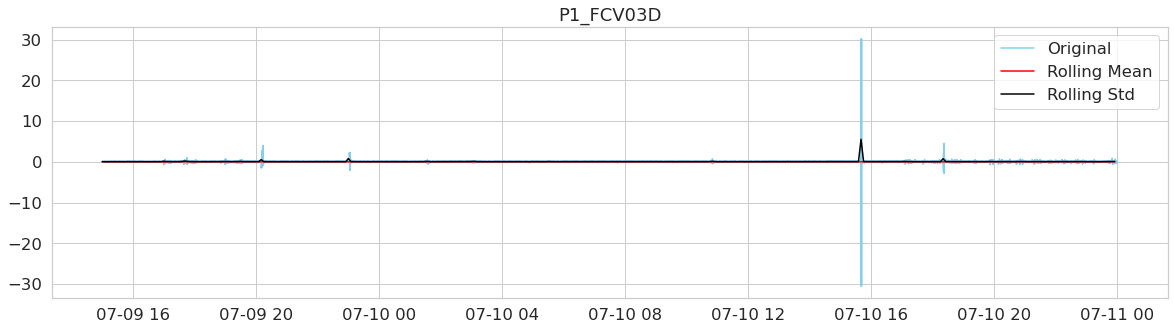

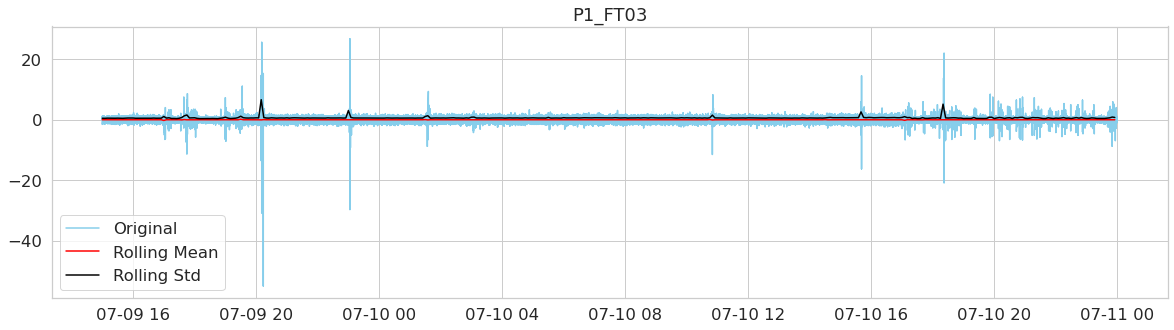

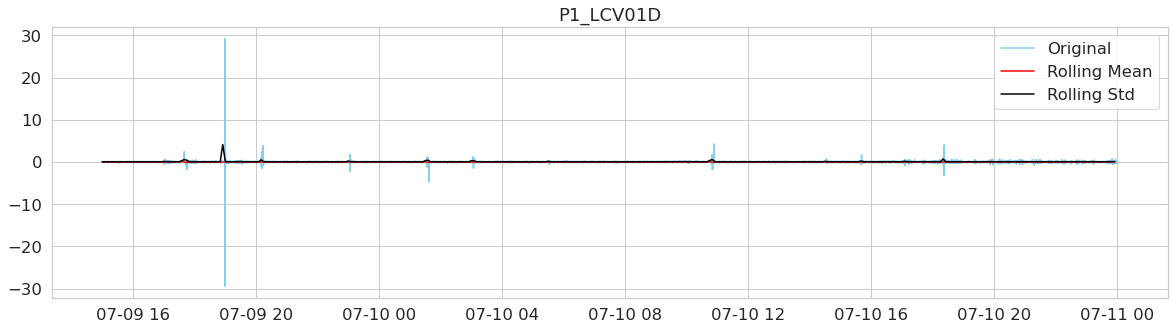

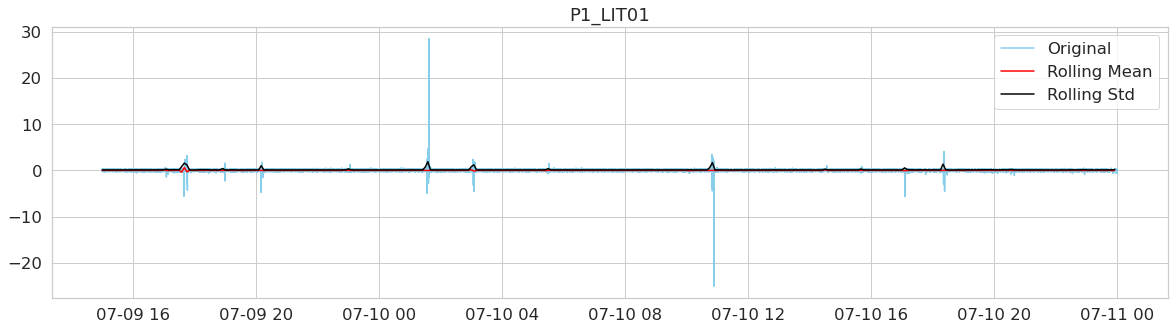

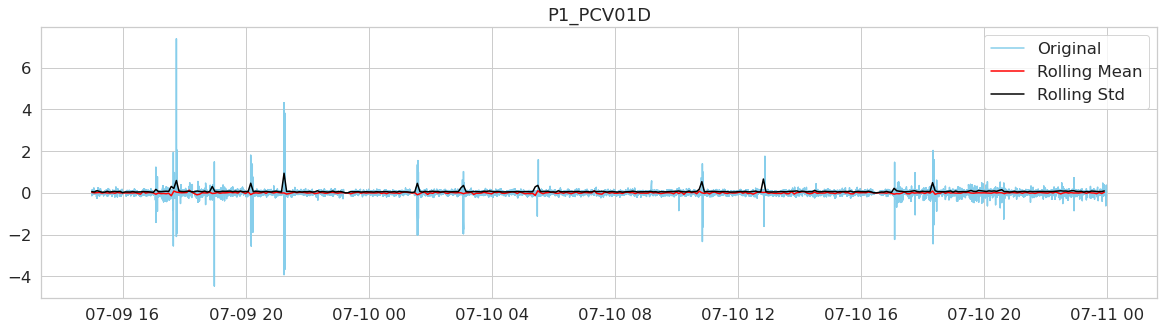

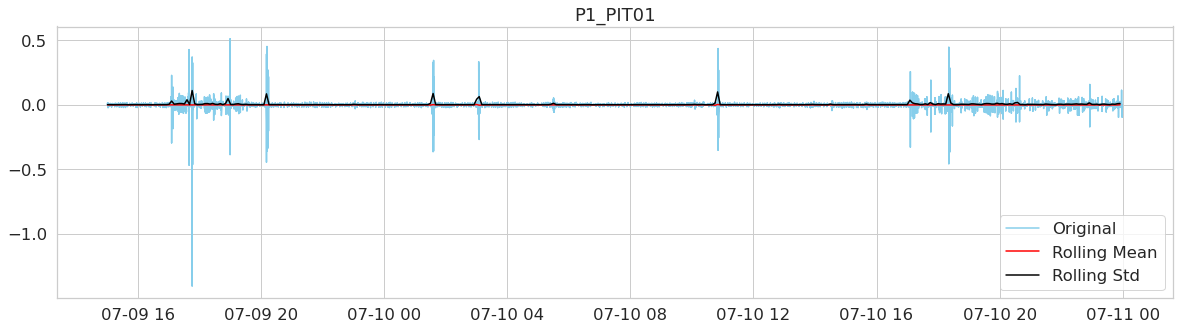

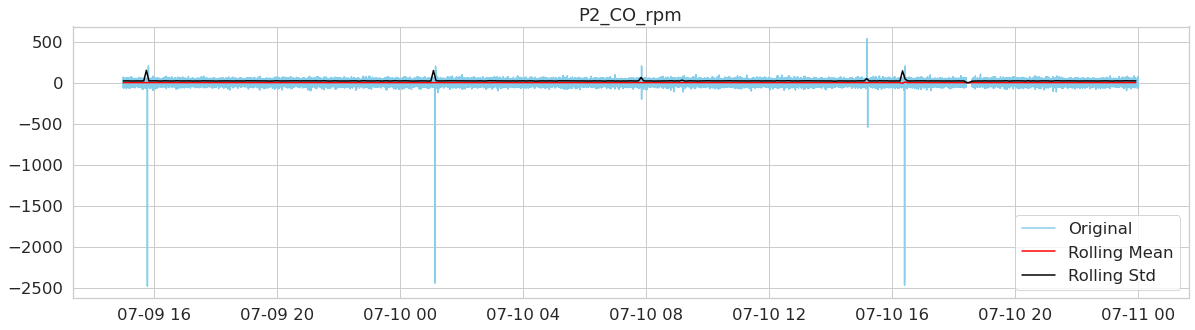

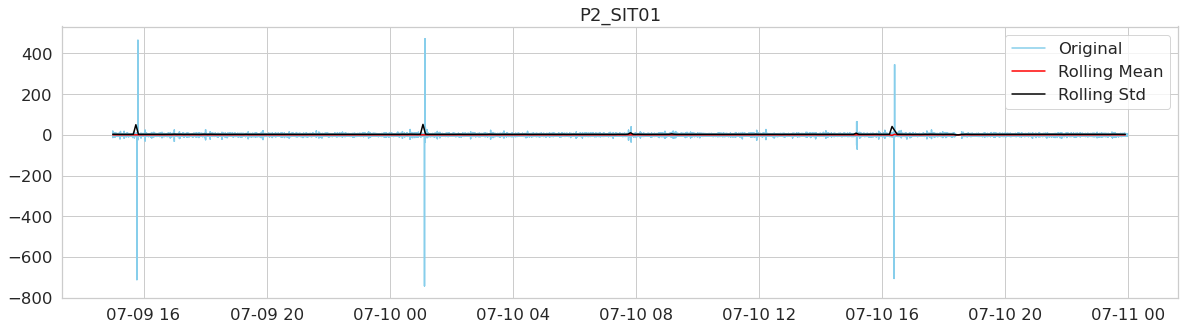

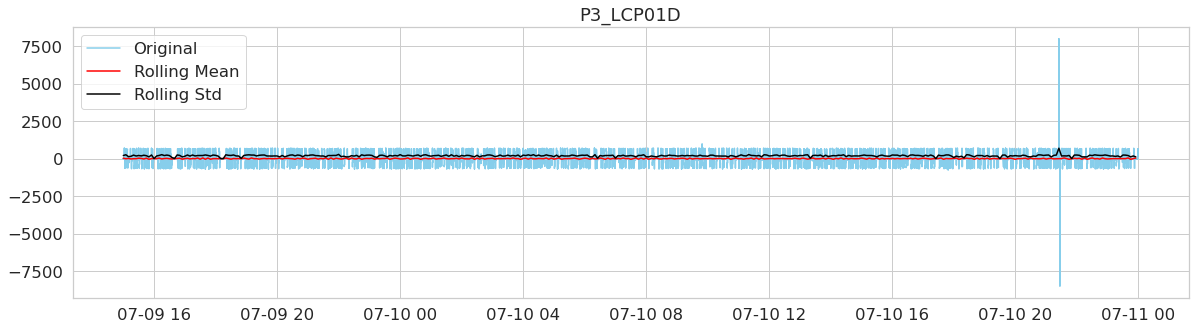

In [343]:
# Resample the entire dataset again by 5 minutes average to see changes
rollmean = hai_data_diff.resample(rule='5T').mean()
rollstd = hai_data_diff.resample(rule='5T').std()
# Plot time series for each sensor with its mean and standard deviation
for name in names:
    _ = plt.figure(figsize=(20,5))
    _ = plt.plot(hai_data_diff[name], color='skyblue', label='Original')
    _ = plt.plot(rollmean[name], color='red', label='Rolling Mean')
    _ = plt.plot(rollstd[name], color='black', label='Rolling Std' )
    _ = plt.legend(loc='best')
    _ = plt.title(name)
    plt.show()

We were able to use Augmented Dickey-Fuller Test (ADF Test) to check the stationary of each variable in the dataset. Stationarity was not achieved in some of the features, so we made the data stationary, such as eliminating the trend and seasonality by using differencing method.

All of the data columns have now become stationary. If the differencing process does not succeed in converting the data to stationary, consider utilizing log transformation and seasonal decomposition instead. We may now use a time-series model to model the data's connection. We'll utilize the VAR (Vector Auto-Regression) model in this case.

#### Splitting the generated Stationary Data 
split data into train and test. We will need this later for VAR analysis

In [344]:
size = 35400   # 25 % 75%
hai_train, hai_test = hai_data_diff[0:-size], hai_data_diff[-size:]
# Check size  
print(hai_train.shape) 
print(hai_test.shape)

(83400, 16)
(35400, 16)


In [345]:
var_model = VAR(hai_train)
res = var_model.select_order(maxlags=14)
print(res.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -74.84      -74.84   3.148e-33      -74.84
1       -87.28      -87.25   1.246e-38      -87.27
2       -88.70      -88.65   2.992e-39      -88.69
3       -89.36      -89.27   1.561e-39      -89.33
4       -89.90      -89.78   9.050e-40      -89.87
5       -90.05      -89.90   7.805e-40      -90.00
6       -90.29      -90.11   6.148e-40      -90.23
7       -90.61      -90.41   4.438e-40      -90.55
8       -90.75      -90.52   3.874e-40      -90.68
9       -90.87      -90.61   3.449e-40      -90.79
10      -91.05      -90.76   2.865e-40      -90.96
11      -91.17      -90.86   2.533e-40      -91.08
12      -91.27      -90.92   2.307e-40      -91.16
13      -91.38      -91.01   2.058e-40      -91.27
14     -91.47*     -91.07*  1.885e-40*     -91.35*
--------------------------------------------------


In [346]:
#Fit VAR model
var_model = VAR(endog=hai_train)
var_model_fit = var_model.fit(maxlags=16)
#Print a summary of the model results
var_model_fit.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 05, May, 2022
Time:                     01:49:02
--------------------------------------------------------------------
No. of Equations:         16.0000    BIC:                   -91.0664
Nobs:                     83386.0    HQIC:                  -91.3460
Log likelihood:       1.92411e+06    FPE:                1.88538e-40
AIC:                     -91.4693    Det(Omega_mle):     1.80582e-40
--------------------------------------------------------------------
Results for equation P1_B2004
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                -0.000000         0.000000           -0.043           0.966
L1.P1_B2004           0.765280         0.004088          187.188           0.000
L1.P1_B2016           0.000002         0.000001          

In [347]:
# Get the lag order
lag_order = var_model_fit.k_ar
print(lag_order)
# Input data for forecasting
input_data = hai_train.values[-lag_order:]
print(input_data)
# forecasting
pred = var_model_fit.forecast(y=input_data, steps=nobs)
pred = (pd.DataFrame(pred, index=hai_test.index, columns= hai_data.columns + '_pred'))
print(pred)

14
[[ 0.0000e+00  4.5800e-03  0.0000e+00  0.0000e+00  0.0000e+00 -7.3830e-02
  -3.5790e-02 -1.9077e-01 -3.3520e-02  5.1110e-02  9.7960e-02  0.0000e+00
   1.0000e+00  1.0000e+00  0.0000e+00  0.0000e+00]
 [ 0.0000e+00 -4.5800e-03  0.0000e+00  0.0000e+00  0.0000e+00 -5.9730e-02
   1.8400e-03 -3.8147e-01 -5.4300e-03 -1.5335e-01  1.4614e-01  0.0000e+00
  -6.0000e+00  3.0000e+00  0.0000e+00  0.0000e+00]
 [ 0.0000e+00  5.0300e-03  0.0000e+00  0.0000e+00  0.0000e+00  2.5429e-01
   1.6500e-02 -1.9067e-01  4.2140e-02  1.0224e-01  1.4786e-01 -7.6000e-04
   2.4000e+01 -1.0000e+00  0.0000e+00  0.0000e+00]
 [ 0.0000e+00  4.8800e-03  0.0000e+00  0.0000e+00  0.0000e+00  4.2020e-02
   5.6600e-03  0.0000e+00 -9.5500e-03  0.0000e+00  1.5591e-01  7.6000e-04
  -2.1000e+01 -2.0000e+00  0.0000e+00  0.0000e+00]
 [ 0.0000e+00  5.1900e-03  0.0000e+00  0.0000e+00  0.0000e+00  4.1440e-02
  -6.4500e-03 -3.8147e-01 -5.0700e-03 -1.0224e-01  1.2924e-01  0.0000e+00
   1.4000e+01 -1.0000e+00  0.0000e+00  0.0000e+00]
 [

In [226]:
max_lag = 8
var_model = VAR(hai_data_diff)
# select the best lag order
lag_results = var_model.select_order(max_lag)
selected_lag = lag_results.aic
print(selected_lag) 

def find_anomalies(squared_errors):
    threshold = np.mean(squared_errors) + 1*np.std(squared_errors)
    predictions = (squared_errors >= threshold).astype(int)
    return predictions, threshold

var = VAR(hai_data_diff)
var_fitresults = var.fit(selected_lag)
squared_errors = var_fitresults.resid.sum(axis=1) ** 2
predictions, threshold = find_anomalies(squared_errors)
data = hai_data_diff.iloc[selected_lag:, :]
data['Predictions'] = predictions.values
data

P1_B2004  P1_B2016  P1_B3004  P1_B3005  P1_B4002  \
time                                                                    
2020-07-09 15:00:08       0.0  -0.00336       0.0       0.0       0.0   
2020-07-09 15:00:09       0.0   0.00168       0.0       0.0       0.0   
2020-07-09 15:00:10       0.0  -0.00091       0.0       0.0       0.0   
2020-07-09 15:00:11       0.0   0.00595       0.0       0.0       0.0   
2020-07-09 15:00:12       0.0   0.00641       0.0       0.0       0.0   
...                       ...       ...       ...       ...       ...   
2020-07-10 23:59:56       0.0  -0.00503       0.0       0.0       0.0   
2020-07-10 23:59:57       0.0  -0.00382       0.0       0.0       0.0   
2020-07-10 23:59:58       0.0  -0.00519       0.0       0.0       0.0   
2020-07-10 23:59:59       0.0   0.00199       0.0       0.0       0.0   
2020-07-11 00:00:00       0.0  -0.00122       0.0       0.0       0.0   

                     P1_FCV01D  P1_FCV03D  P1_FT03  P1_LCV01D  P1_LIT01  \
time                                                                      
2020-07-09 15:00:08    0.14054   -0.03968 -0.38148   -0.09647  -0.25556   
2020-07-09 15:00:09    0.16556    0.02345 -0.38143    0.05554   0.00000   
2020-07-09 15:00:10   -0.04433    0.02599  0.19067    0.01738  -0.05115   
2020-07-09 15:00:11    0.17210   -0.01162 -0.19067   -0.01071  -0.05111   
2020-07-09 15:00:12   -0.01558    0.01388  0.57214    0.01432  -0.05109   
...                        ...        ...      ...        ...       ...   
2020-07-10 23:59:56    0.00000   -0.01554 -0.19070    0.05369   0.05108   
2020-07-10 23:59:57    0.00000    0.03751  0.19070    0.03094   0.00000   
2020-07-10 23:59:58    0.00000    0.02273 -0.19070    0.00532   0.05112   
2020-07-10 23:59:59    0.00000   -0.01206 -0.19077    0.03067  -0.05112   
2020-07-11 00:00:00    0.00000    0.02272  0.38147    0.04888   0.00000   

                     P1_PCV01D  P1_PIT01  P2_CO_rpm  P2_SIT01  P3_LCP01D  \
time                                                                       
2020-07-09 15:00:08   -0.05532  -0.00076      -61.0      -1.0        0.0   
2020-07-09 15:00:09   -0.06411   0.00305      -11.0       0.0        0.0   
2020-07-09 15:00:10   -0.04815   0.01449        0.0       0.0        8.0   
2020-07-09 15:00:11   -0.10439   0.01069       64.0      -4.0        0.0   
2020-07-09 15:00:12   -0.13086  -0.00077       21.0      -6.0        0.0   
...                        ...       ...        ...       ...        ...   
2020-07-10 23:59:56   -0.05467   0.00000       30.0      -2.0      184.0   
2020-07-10 23:59:57   -0.06740  -0.00076       24.0       1.0      184.0   
2020-07-10 23:59:58   -0.02834  -0.00153      -16.0      -3.0      168.0   
2020-07-10 23:59:59   -0.03979  -0.01144      -13.0       2.0      160.0   
2020-07-11 00:00:00    0.01404  -0.00077      -53.0      -2.0       80.0   

                     attack  Predictions  
time                                      
2020-07-09 15:00:08     0.0            0  
2020-07-09 15:00:09     0.0            0  
2020-07-09 15:00:10     0.0            0  
2020-07-09 15:00:11     0.0            0  
2020-07-09 15:00:12     0.0            0  
...                     ...          ...  
2020-07-10 23:59:56     0.0            0  
2020-07-10 23:59:57     0.0            0  
2020-07-10 23:59:58     0.0            0  
2020-07-10 23:59:59     0.0            0  
2020-07-11 00:00:00     0.0            0  

[118793 rows x 17 columns]

In [228]:
data['Predictions'].value_counts()


0    118453
1       340
Name: Predictions, dtype: int64

## <b><span style="color:blue">Modelling </b></span>

### Anomaly Detection

Anomaly detection is the identification of events in a dataset that do not conform to the expected pattern. 



### Models 

In this step, I will perform the following learning algorithms to detect anomalies or attack on the system:

1. Vector Auto Regression (VAR)
2. Isolation Forest



#### Applying Vector Auto Regression (VAR)

In a VAR model, each variable is a linear function of the past values of itself and the past values of all the other variables. Creating a validation set for time series problems is tricky because we have to take into account the time component. One cannot directly use the train_test_split or k-fold validation since this will disrupt the pattern in the series. The validation set should be created considering the date and time values.


The VAR model will capture the linear relations between multiple variables in the dataset. So , for each input series , a regression is carried out . The original variables are regressed against their own lagged values of other variables.
In other words VAR model will be used to approximate the system and monitor the residuals as a serially independent series.

Let's determine the appropriate maximum lag length for the variables in the VAR.

In [239]:
msk = np.random.rand(len(hai_data_diff)) < 0.8
train = hai_data_diff[msk]
test = hai_data_diff[~msk]
model = VAR(hai_data_diff) #recall that rawData is without difference operation
for i in [1,2,3,4,5,6,7,8,9,10,11,12, 13, 14, 15, 16,17]:
    result = model.fit(i)
    try:
        print('Lag Order =', i)
        print('AIC : ', result.aic)
        print('BIC : ', result.bic)
        print('FPE : ', result.fpe)
        print('HQIC: ', result.hqic, '\n')
    except:
        continue


Lag Order = 1
AIC :  -72.39644718514458
BIC :  -72.37427232404552
FPE :  3.619282459910801e-32
HQIC:  -72.38976934336593 

Lag Order = 2
AIC :  -83.94449795327594
BIC :  -83.90145230974613
FPE :  3.494360865049717e-37
HQIC:  -83.93153498122818 

Lag Order = 3
AIC :  -84.85710586201586
BIC :  -84.79318912096811
FPE :  1.4029014825430554e-37
HQIC:  -84.83785766009629 

Lag Order = 4
AIC :  -85.321372935275
BIC :  -85.23658478161464
FPE :  8.818577715293422e-38
HQIC:  -85.2958394038785 

Lag Order = 5
AIC :  -85.77798736573214
BIC :  -85.672327484357
FPE :  5.585903384820145e-38
HQIC:  -85.74616840525115 

Lag Order = 6
AIC :  -85.89861542057317
BIC :  -85.77208349637355
FPE :  4.951141316569263e-38
HQIC:  -85.86051093139767 

Lag Order = 7
AIC :  -86.1095730817476
BIC :  -85.96216879960633
FPE :  4.009475606043637e-38
HQIC:  -86.06518296426519 

Lag Order = 8
AIC :  -86.39643616934971
BIC :  -86.22815921414212
FPE :  3.0095705016061685e-38
HQIC:  -86.34576032394554 

Lag Order = 9
AIC : 

In [240]:
x = model.select_order(maxlags=12)
x.summary()

<class 'statsmodels.iolib.table.SimpleTable'>

In [266]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order) 

NameError: name 'model_fitted' is not defined

In [ ]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df.index[-nobs:], columns=df.columns + '_2d')
df_forecast

In [ ]:
model = VAR(df_differenced)
results = model.fit(maxlags=15, ic='aic')
results.summary()

####  Applying Isolation Forest
Isolation Forest model is an anomaly detection algorithm and rather than modeling the normal points, it discovers anomalies using isolation (how remote a data point is from the rest of the data).


I'll utilize the Principal Component Analysis (PCA) method to extract additional features for anomaly detection modeling. The data must be scaled and standardized before PCA can be applied appropriately. This is due to the fact that PCA and the majority of learning algorithms are based on distance.  PCA is used to calculate the a projection of dataset and select number of dims. as input to the model.

First we scale the data using the standard scaler followed by utilizing PCA and view the important components

In [63]:
# Extract the names of the numerical columns
hai_dataProcess = hai_data.drop(['attack'], axis=1)
names=hai_dataProcess.columns
x = hai_data[names]
scaler = StandardScaler()
pca = PCA()
pipeline = make_pipeline(scaler, pca)
pipeline.fit(x)

Pipeline(steps=[('standardscaler', StandardScaler()), ('pca', PCA())])

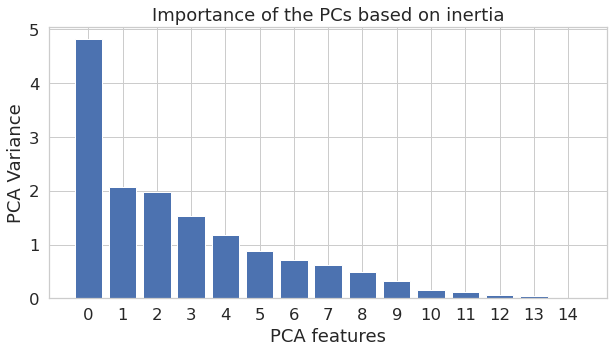

In [67]:
# Plot the principal components against their inertia
features = range(pca.n_components_)
_ = plt.figure(figsize=(10, 5))
_ = plt.bar(features, pca.explained_variance_)
_ = plt.xlabel('PCA features')
_ = plt.ylabel('PCA Variance')
_ = plt.xticks(features)
_ = plt.title("Importance of the PCs based on inertia")
plt.show()

It appears that the first three or we could say 4  principal components are the most important as per the features extracted by the PCA plot above

In [68]:
# Calculate PCA with 4 components
pca = PCA(n_components=4)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, columns = ['pc1','pc2','pc3','pc4'])


We will check the stationariy and auto-correlation of the PCs just to be sure.

In [72]:
# Run Augmented Dickey Fuller Tests on those PCs
result1 = adfuller(principalDf['pc1'])
result2 = adfuller(principalDf['pc2'])
result3 = adfuller(principalDf['pc3'])
result4 = adfuller(principalDf['pc4'])


# Print p-values
print(result1[1])
print(result2[1])
print(result3[1])
print(result4[1])

0.0
0.0
0.4217566771233314
0.02917776784577802


Now, let’s check for autocorrelation in both of these principal components using ACF plots which is used as an indication that the model is appropriate for the time series 

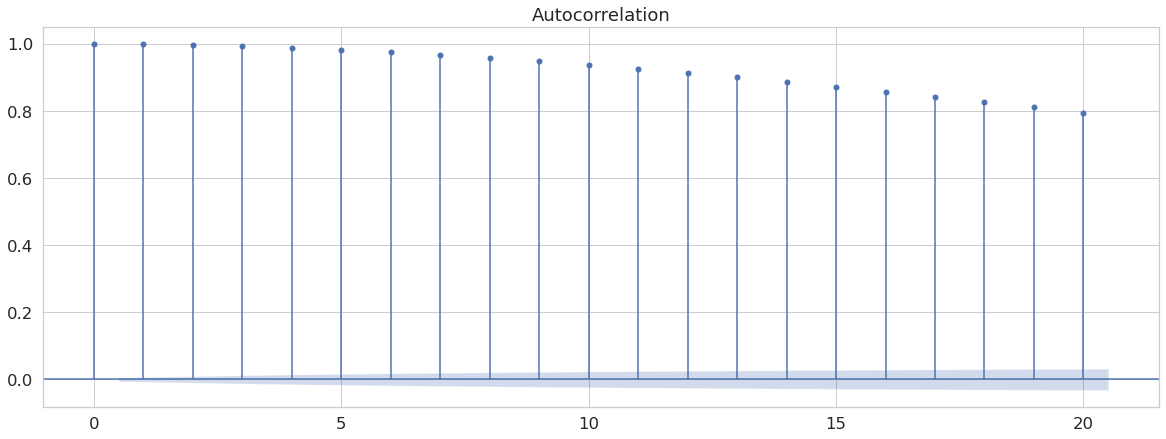

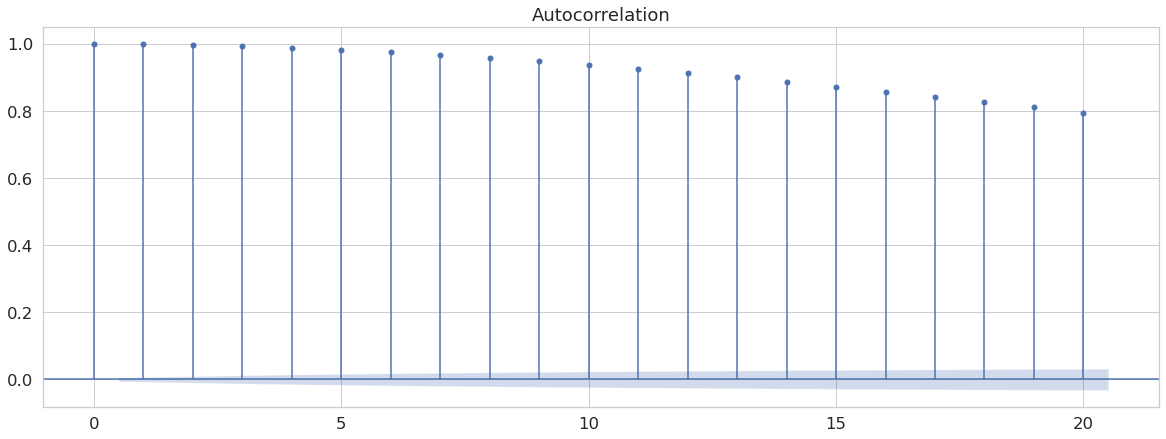

In [103]:
# Plot ACF
plot_acf(principalDf.pc1.dropna(), lags=20, alpha=0.06)

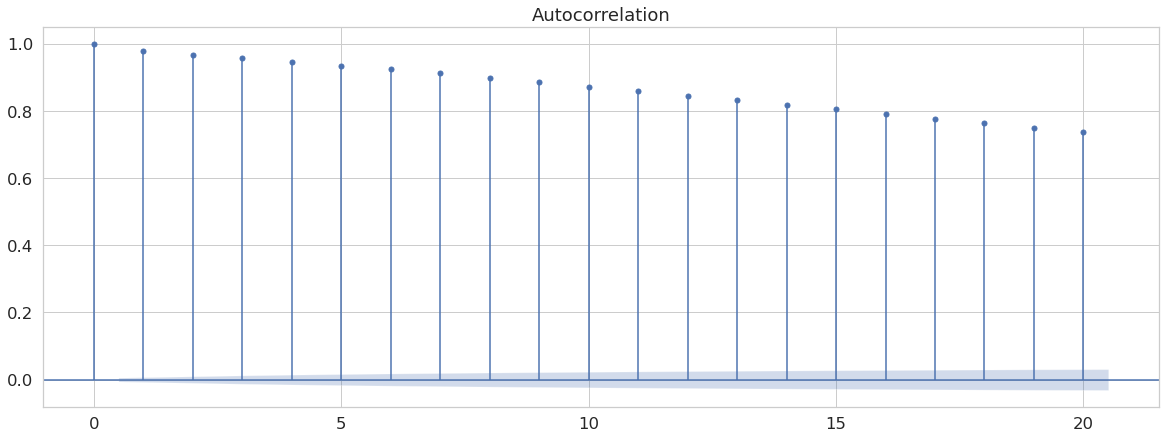

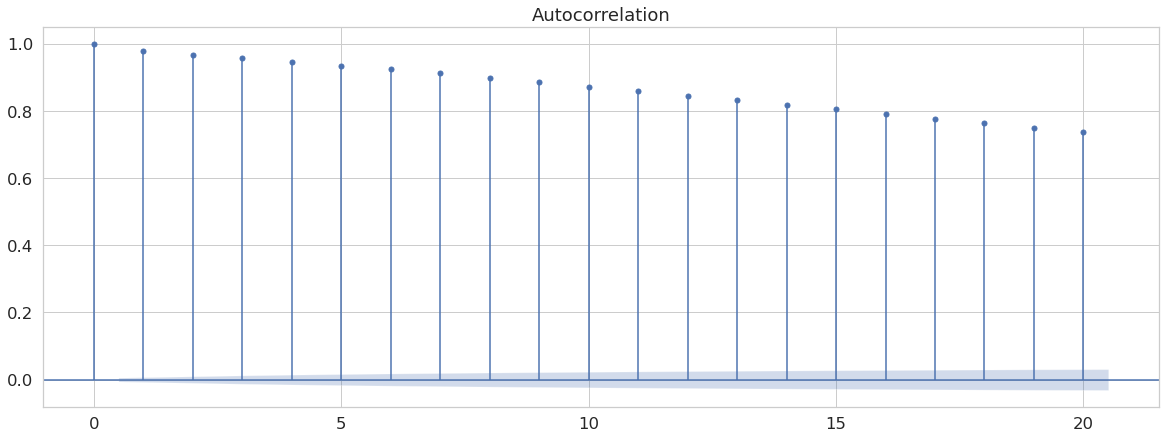

In [104]:
plot_acf(principalDf.pc2.dropna(), lags=20, alpha=0.05)

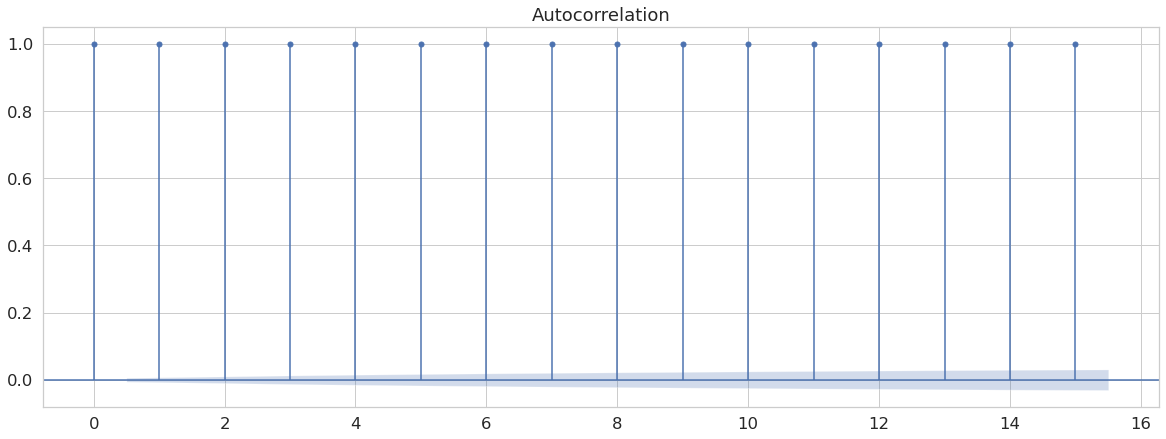

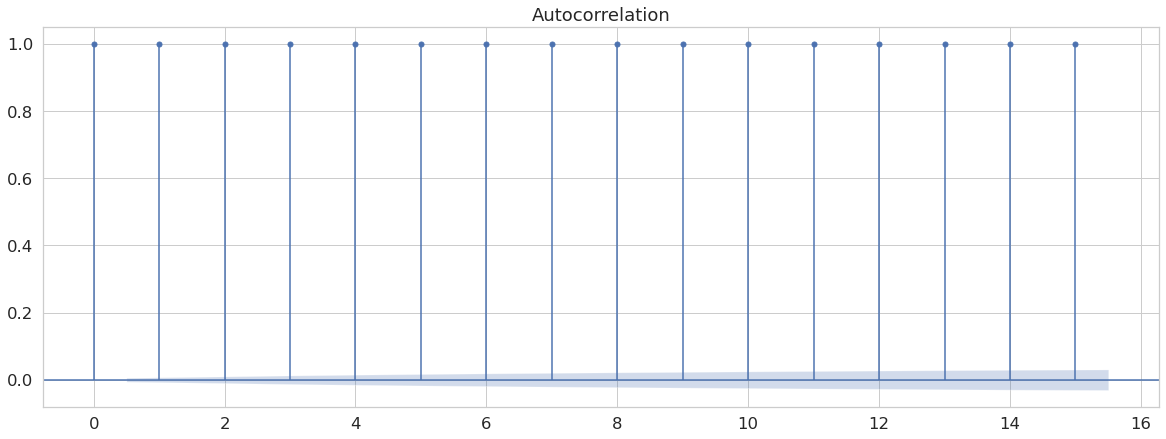

In [107]:
plot_acf(principalDf.pc3.dropna(), lags=15, alpha=0.05)

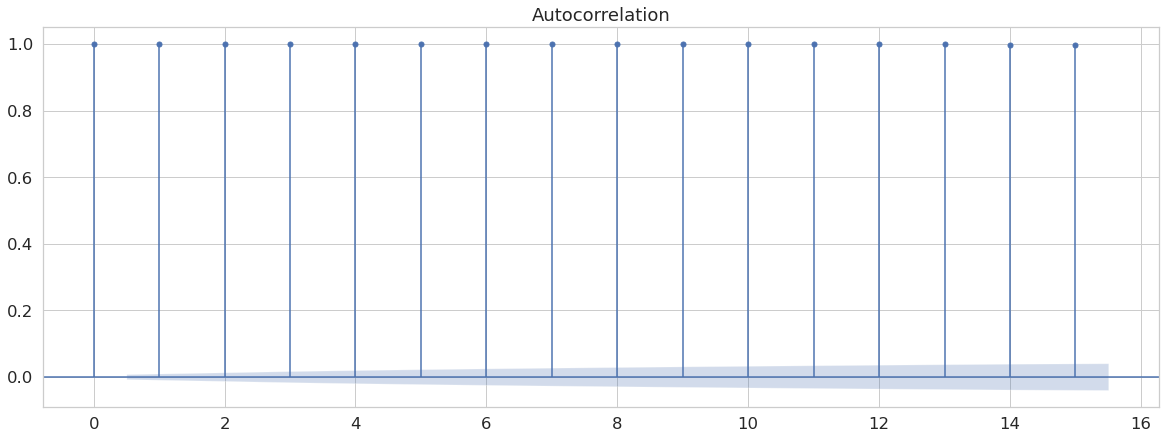

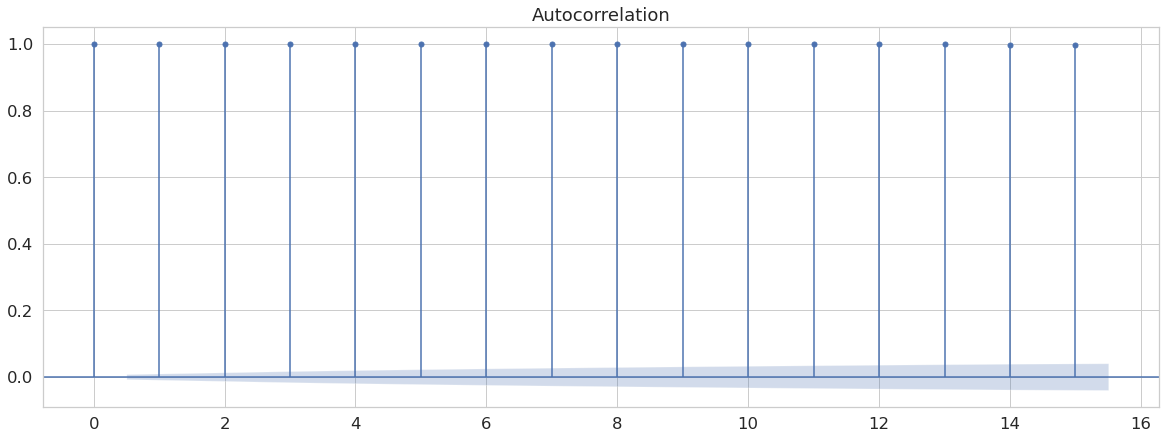

In [108]:
plot_acf(principalDf.pc4.dropna(), lags=15, alpha=0.01)

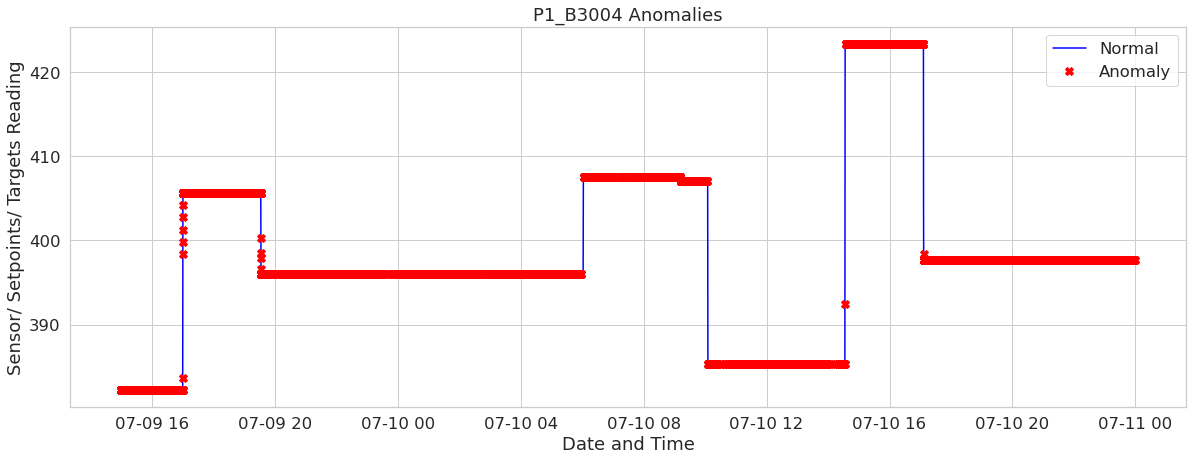

In [115]:
outliers_fraction = 0.10
model =  IsolationForest(contamination=outliers_fraction)
model.fit(principalDf.values) 
principalDf['attack'] = pd.Series(model.predict(principalDf.values))
# visualization
hai_data['attack'] = pd.Series(principalDf['attack'].values, index=hai_data.index)
a = hai_data.loc[hai_data['attack'] == -1] #anomaly
_ = plt.figure(figsize=(20,7))
_ = plt.plot(hai_data['P1_B3004'], color='blue', label='Normal')
_ = plt.plot(a['P1_B3004'], linestyle='none', marker='X', color='red', markersize=8, label='Anomaly')
_ = plt.xlabel('Date and Time')
_ = plt.ylabel('Sensor/ Setpoints/ Targets Reading')
_ = plt.title('P1_B3004 Anomalies')
_ = plt.legend(loc='best')
plt.show();

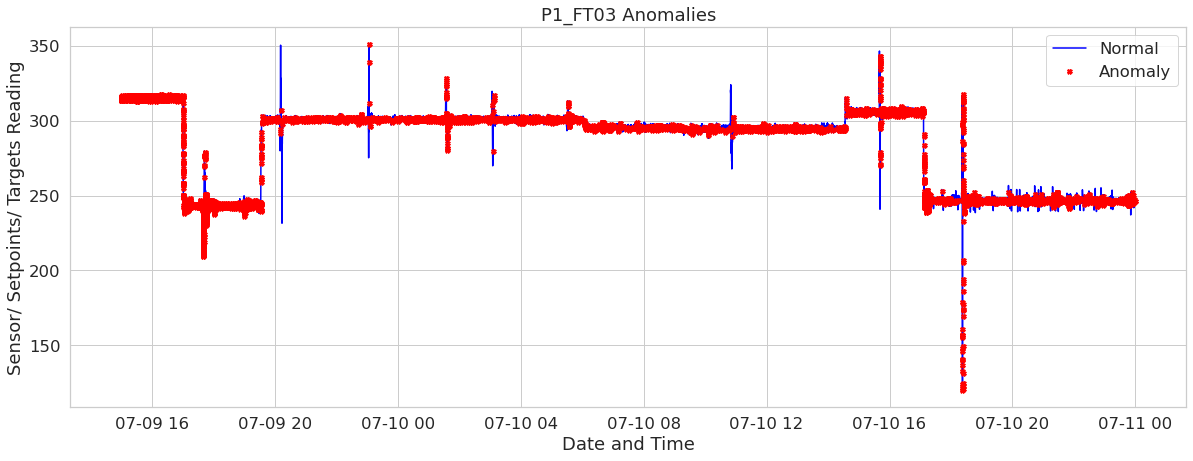

In [114]:
# Assume that 10 % of the entire data set are anomalies
 
outliers_fraction = 0.10
model =  IsolationForest(contamination=outliers_fraction)
model.fit(principalDf.values) 
principalDf['attack'] = pd.Series(model.predict(principalDf.values))
# visualization
hai_data['attack'] = pd.Series(principalDf['attack'].values, index=hai_data.index)
a = hai_data.loc[hai_data['attack'] == -1] #anomaly
_ = plt.figure(figsize=(20,7))
_ = plt.plot(hai_data['P1_FT03'], color='blue', label='Normal')
_ = plt.plot(a['P1_FT03'], linestyle='none', marker='X', color='red', markersize=5, label='Anomaly')
_ = plt.xlabel('Date and Time')
_ = plt.ylabel('Sensor/ Setpoints/ Targets Reading')
_ = plt.title('P1_FT03 Anomalies')
_ = plt.legend(loc='best')
plt.show();

## <b><span style="color:blue">References </b></span>

1. Ref 1
2. Ref 2 